In [6]:
!pip install optuna

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Dataset Imbalance: 6.68% are Defaulters.


/tmp/ipython-input-4237880124.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')



========== 🏆 FINAL MODEL PERFORMANCE ==========
AUC Score:         0.8286
Optimal Threshold: 0.4782
Accuracy:          0.8462
Precision:         0.2517
Recall:            0.6599
F1-Score:          0.3644

========== ⚖️ AGE BIAS AUDIT ==========
Young Approval Rate (<30):  51.09%
Senior Approval Rate (30+): 84.41%
Disparate Impact Ratio:     0.6053
🚨 ALERT: Model shows potential age bias (below 80% rule).


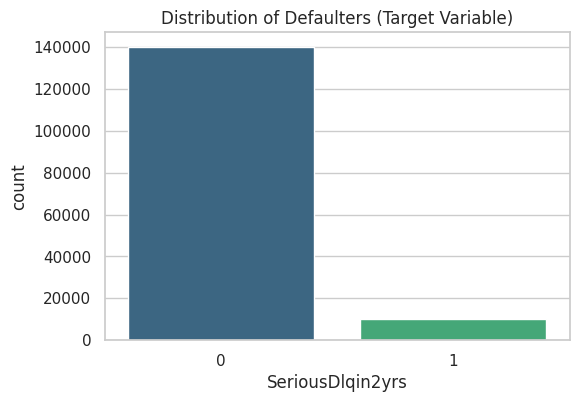

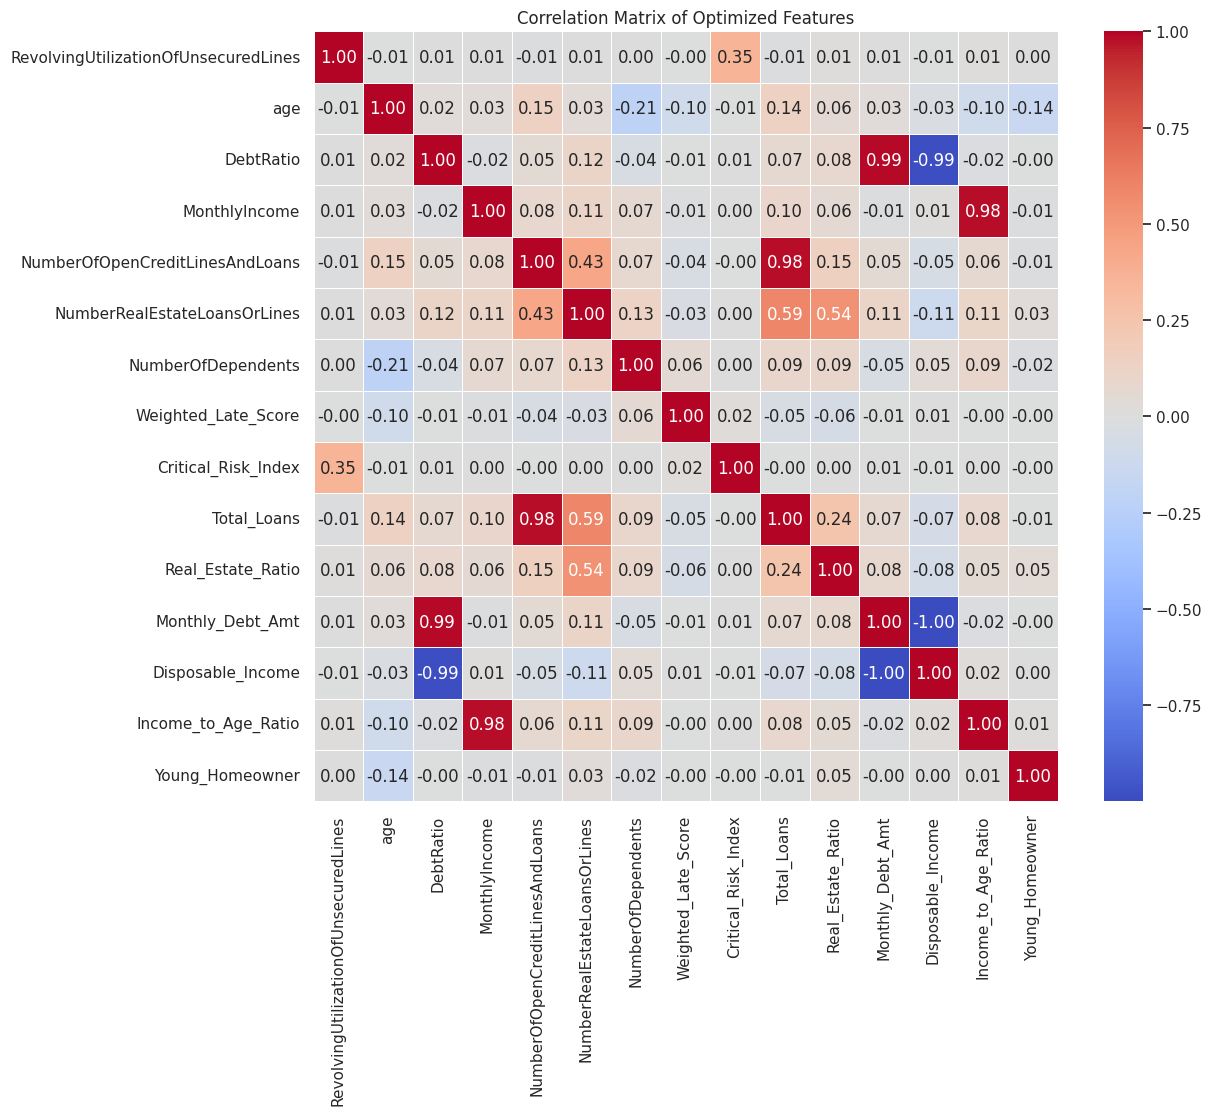

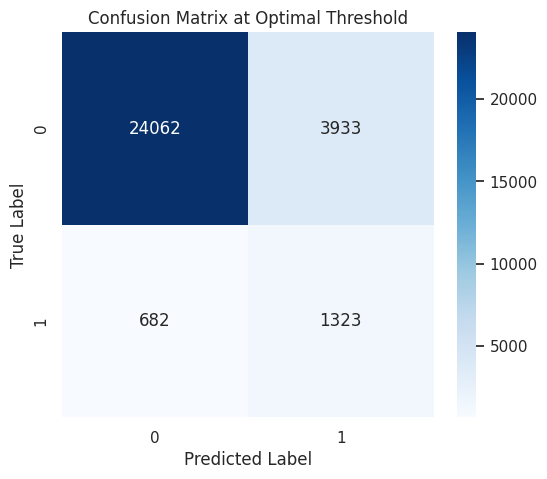

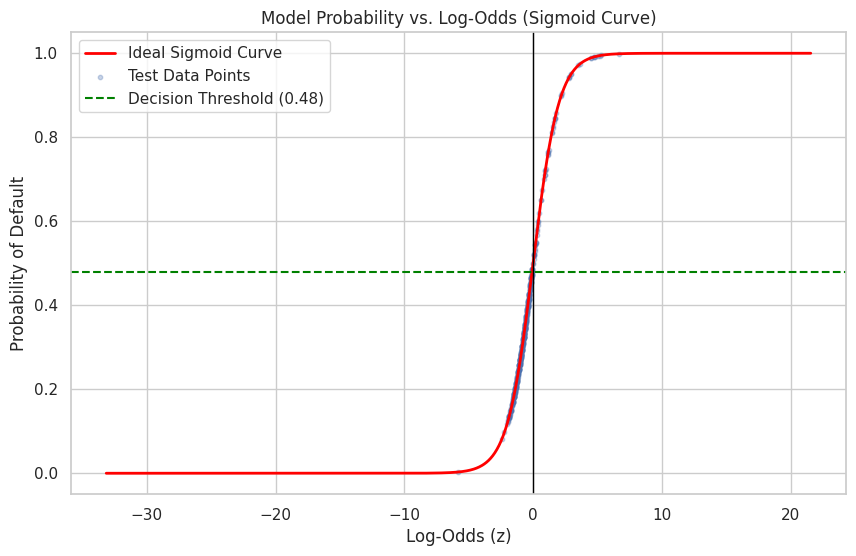

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 1. LOAD & INITIAL EDA 📊
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

print("========== 📊 INITIAL DATA HEALTH CHECK ==========")
# Check for Missing Values
print(f"Missing Values:\n{df.isnull().sum()}\n")

# Check Class Imbalance
default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

# Visualization 1: Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')

# ==========================================
# 2. DATA CLEANING & OUTLIERS 🧹
# ==========================================
# Handle "System Error" outliers (96 and 98 lates)
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate']

for col in late_cols:
    # We replace impossible values with the median of the non-error data
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTING & IMPUTATION 🧠
# ==========================================
# Split FIRST to avoid data leakage
X_raw = df.drop('SeriousDlqin2yrs', axis=1)
y_raw = df['SeriousDlqin2yrs']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

# Smart Imputation: Calculate medians on TRAIN only
income_median = X_train_raw['MonthlyIncome'].median()
dep_median = X_train_raw['NumberOfDependents'].median()

# Apply to both
for d in [X_train_raw, X_test_raw]:
    d['MonthlyIncome'] = d['MonthlyIncome'].fillna(income_median)
    d['NumberOfDependents'] = d['NumberOfDependents'].fillna(dep_median)

# ==========================================
# 4. OPTIMIZED FEATURE ENGINEERING 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # Behavior Interaction
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # Financial Capacity
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    # Income Metrics
    d['Monthly_Debt_Amt'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amt']

    # Fairness/Maturity Proxies
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Drop raw late columns to reduce multicollinearity
    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                           'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfTimes90DaysLate'])

X_train_eng = engineer_features(X_train_raw)
X_test_eng = engineer_features(X_test_raw)

# Visualization 2: Final Feature Correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_eng.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Optimized Features')
plt.savefig('correlation_heatmap.png')

# ==========================================
# 5. SCALING & MODELING ⚖️
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

# Logistic Regression with Class Weights to handle imbalance
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Find Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
best_t = thresholds[optimal_idx]

y_pred = (y_probs >= best_t).astype(int)

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"AUC Score:         {roc_auc_score(y_test, y_probs):.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred):.4f}")
print(f"Recall:            {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:          {f1_score(y_test, y_pred):.4f}")

# Visualization 3: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal Threshold')
plt.savefig('confusion_matrix.png')

# ==========================================
# 7. SIGMOID FUNCTION VISUALIZATION 📈
# ==========================================
# Calculate Log-odds (z)
z = model.decision_function(X_test_scaled)

plt.figure(figsize=(10, 6))
# Create a smooth sigmoid curve line
z_smooth = np.linspace(z.min(), z.max(), 1000)
p_smooth = 1 / (1 + np.exp(-z_smooth))
plt.plot(z_smooth, p_smooth, color='red', label='Ideal Sigmoid Curve', linewidth=2)

# Plot actual data points (sampled for readability)
indices = np.random.choice(len(z), 500)
plt.scatter(z[indices], y_probs[indices], alpha=0.3, s=10, label='Test Data Points')

plt.axhline(y=best_t, color='green', linestyle='--', label=f'Decision Threshold ({best_t:.2f})')
plt.axvline(x=0, color='black', linewidth=1)
plt.title('Model Probability vs. Log-Odds (Sigmoid Curve)')
plt.xlabel('Log-Odds (z)')
plt.ylabel('Probability of Default')
plt.legend()
plt.savefig('sigmoid_curve.png')

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test_raw['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ AGE BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")
print(f"Disparate Impact Ratio:     {young_app/senior_app:.4f}")

if (young_app/senior_app) < 0.8:
    print("🚨 ALERT: Model shows potential age bias (below 80% rule).")
else:
    print("✅ Model passes the 80% fairness rule.")

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Dataset Imbalance: 6.68% are Defaulters.


/tmp/ipython-input-2585719030.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')



========== 🏆 FINAL MODEL PERFORMANCE ==========
AUC Score:         0.8286
Optimal Threshold: 0.4782
Accuracy:          0.8462
Precision:         0.2517
Recall:            0.6599
F1-Score:          0.3644
✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'
✅ ROC Curve Generated: 'roc_curve_lr.png'
✅ Sigmoid Curve Generated: 'sigmoid_curve.png'

========== ⚖️ AGE BIAS AUDIT ==========
Young Approval Rate (<30):  51.09%
Senior Approval Rate (30+): 84.41%
Disparate Impact Ratio:     0.6053
🚨 ALERT: Model shows potential age bias (below 80% rule).


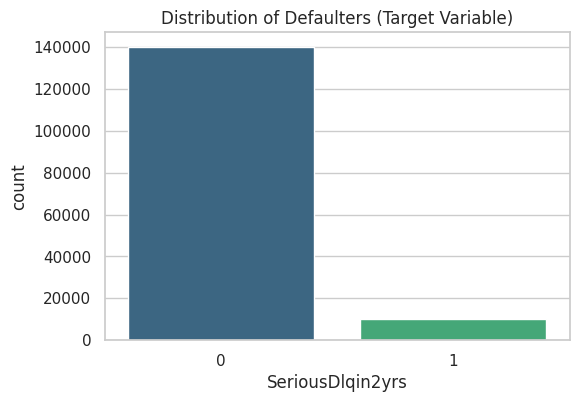

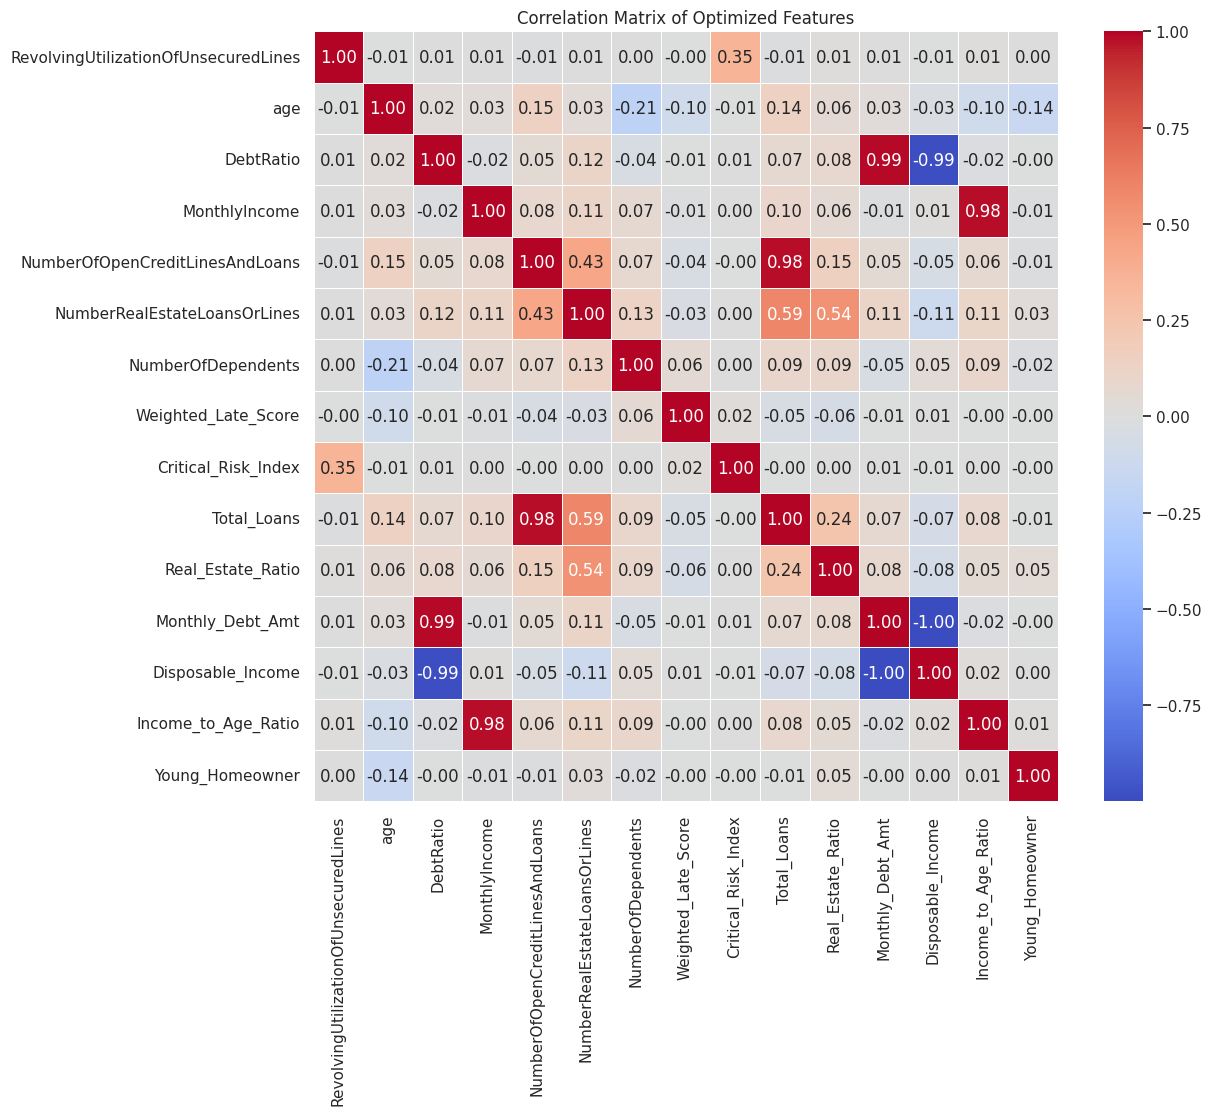

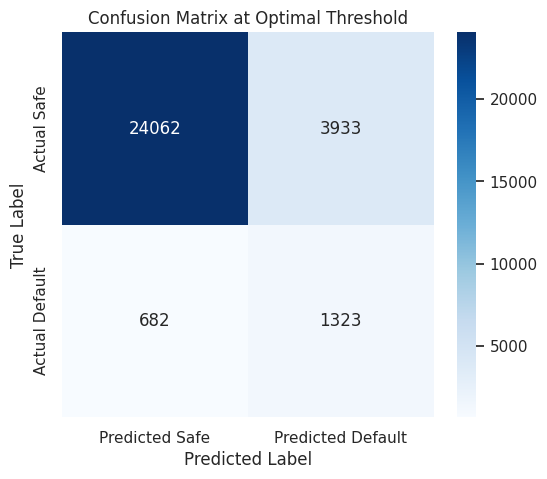

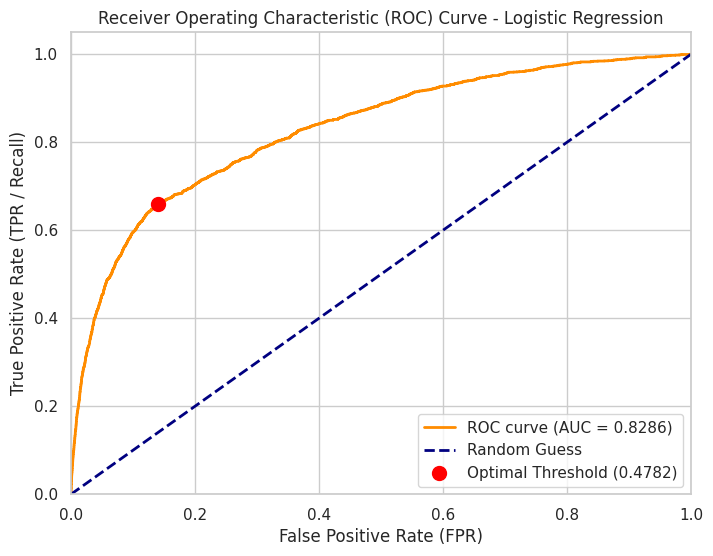

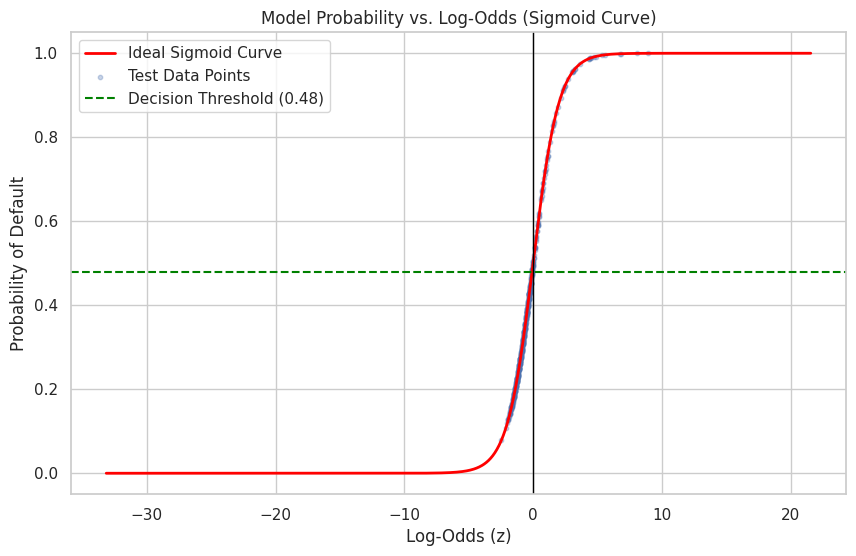

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 1. LOAD & INITIAL EDA 📊
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

print("========== 📊 INITIAL DATA HEALTH CHECK ==========")
# Check for Missing Values
print(f"Missing Values:\n{df.isnull().sum()}\n")

# Check Class Imbalance
default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

# Visualization 1: Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')

# ==========================================
# 2. DATA CLEANING & OUTLIERS 🧹
# ==========================================
# Handle "System Error" outliers (96 and 98 lates)
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate']

for col in late_cols:
    # We replace impossible values with the median of the non-error data
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTING & IMPUTATION 🧠
# ==========================================
# Split FIRST to avoid data leakage
X_raw = df.drop('SeriousDlqin2yrs', axis=1)
y_raw = df['SeriousDlqin2yrs']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

# Smart Imputation: Calculate medians on TRAIN only
income_median = X_train_raw['MonthlyIncome'].median()
dep_median = X_train_raw['NumberOfDependents'].median()

# Apply to both
for d in [X_train_raw, X_test_raw]:
    d['MonthlyIncome'] = d['MonthlyIncome'].fillna(income_median)
    d['NumberOfDependents'] = d['NumberOfDependents'].fillna(dep_median)

# ==========================================
# 4. OPTIMIZED FEATURE ENGINEERING 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # Behavior Interaction
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # Financial Capacity
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    # Income Metrics
    d['Monthly_Debt_Amt'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amt']

    # Fairness/Maturity Proxies
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Drop raw late columns to reduce multicollinearity
    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                           'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfTimes90DaysLate'])

X_train_eng = engineer_features(X_train_raw)
X_test_eng = engineer_features(X_test_raw)

# Visualization 2: Final Feature Correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_eng.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Optimized Features')
plt.savefig('correlation_heatmap.png')

# ==========================================
# 5. SCALING & MODELING ⚖️
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

# Logistic Regression with Class Weights to handle imbalance
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Find Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
best_t = thresholds[optimal_idx]

y_pred = (y_probs >= best_t).astype(int)
auc_score = roc_auc_score(y_test, y_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)
rec_val = tp / (tp + fn)

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred):.4f}")
print(f"Recall:            {rec_val:.4f}")
print(f"F1-Score:          {f1_score(y_test, y_pred):.4f}")

# Visualization 3: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal Threshold')
plt.savefig('confusion_matrix_lr.png')
print("✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'")

# --- 🚀 NEW: Visualizing the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
# Marking the optimal threshold point
plt.scatter(fpr_val, rec_val, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lr.png')
print("✅ ROC Curve Generated: 'roc_curve_lr.png'")

# ==========================================
# 7. SIGMOID FUNCTION VISUALIZATION 📈
# ==========================================
# Calculate Log-odds (z)
z = model.decision_function(X_test_scaled)

plt.figure(figsize=(10, 6))
# Create a smooth sigmoid curve line
z_smooth = np.linspace(z.min(), z.max(), 1000)
p_smooth = 1 / (1 + np.exp(-z_smooth))
plt.plot(z_smooth, p_smooth, color='red', label='Ideal Sigmoid Curve', linewidth=2)

# Plot actual data points (sampled for readability)
indices = np.random.choice(len(z), 500)
plt.scatter(z[indices], y_probs[indices], alpha=0.3, s=10, label='Test Data Points')

plt.axhline(y=best_t, color='green', linestyle='--', label=f'Decision Threshold ({best_t:.2f})')
plt.axvline(x=0, color='black', linewidth=1)
plt.title('Model Probability vs. Log-Odds (Sigmoid Curve)')
plt.xlabel('Log-Odds (z)')
plt.ylabel('Probability of Default')
plt.legend()
plt.savefig('sigmoid_curve.png')
print("✅ Sigmoid Curve Generated: 'sigmoid_curve.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test_raw['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ AGE BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")
print(f"Disparate Impact Ratio:     {young_app/senior_app:.4f}")

if (young_app/senior_app) < 0.8:
    print("🚨 ALERT: Model shows potential age bias (below 80% rule).")
else:
    print("✅ Model passes the 80% fairness rule.")
print("==========================================")


========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Dataset Imbalance: 6.68% are Defaulters.


/tmp/ipython-input-2217056006.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')



========== 🏆 FINAL MODEL PERFORMANCE ==========
AUC Score:         0.8286
Optimal Threshold: 0.4782
Accuracy:          0.8462
Precision:         0.2517
Recall:            0.6599
F1-Score:          0.3644
✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'
✅ ROC Curve Generated: 'roc_curve_lr.png'
✅ Sigmoid Curve Generated: 'sigmoid_curve.png'

========== ⚖️ AGE BIAS AUDIT ==========
Young Approval Rate (<30):  51.09%
Senior Approval Rate (30+): 84.41%
Disparate Impact Ratio:     0.6053
🚨 ALERT: Model shows potential age bias (below 80% rule).

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Risk (Manual Review):   0.15 to 0.4782
High Risk (Auto-Reject):       > 0.4782

--- TIER IMPACT SUMMARY ---
                  Risk_Tier  Total_Applicants  Actual_Defaulters
    High Risk (Auto-Reject)              5256               1323
    Low Risk (Auto-Approve)              1065                  7
Medium Risk (Manual Review)             23

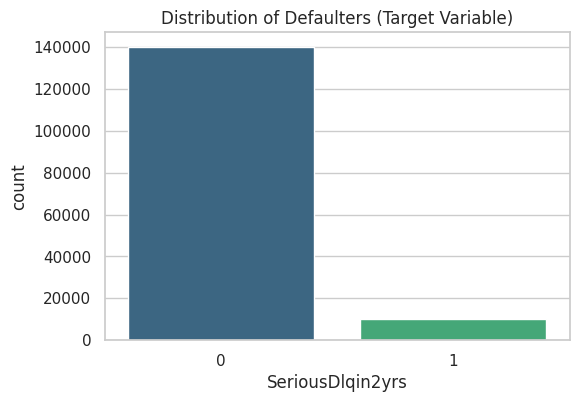

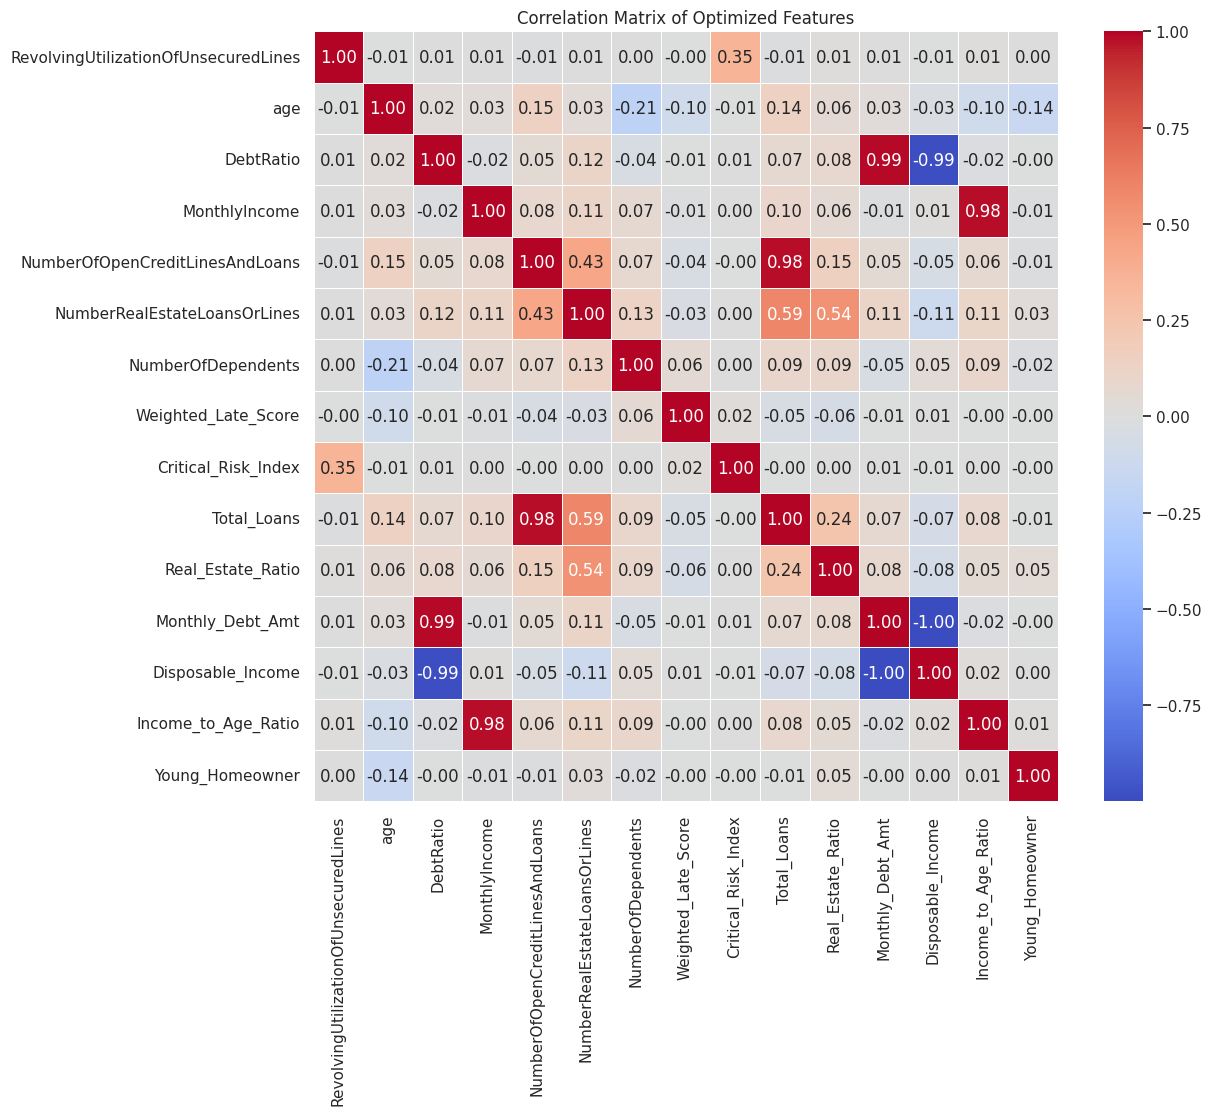

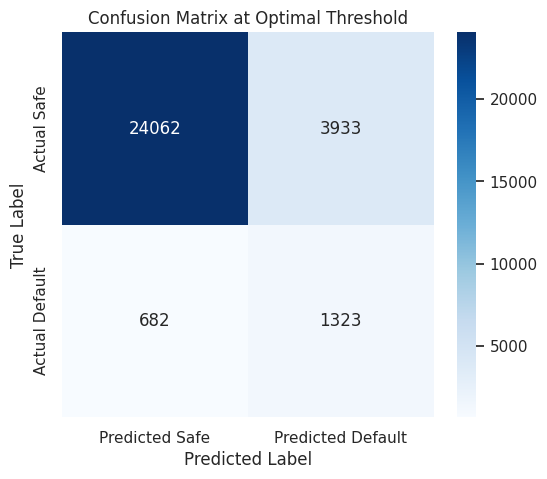

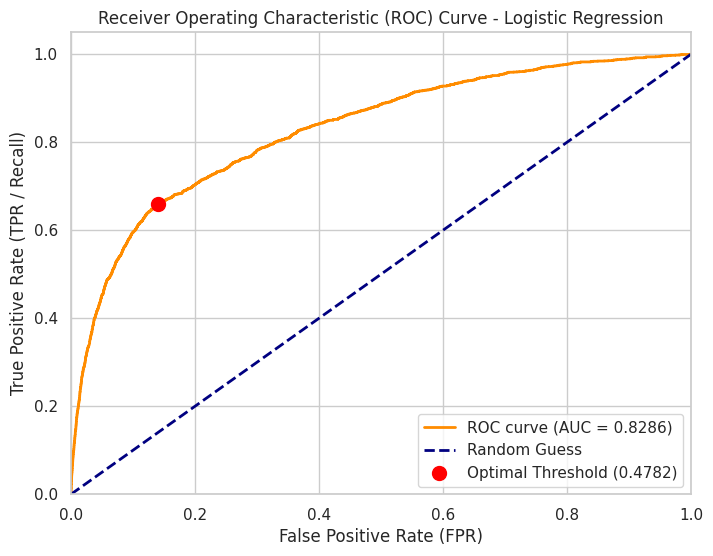

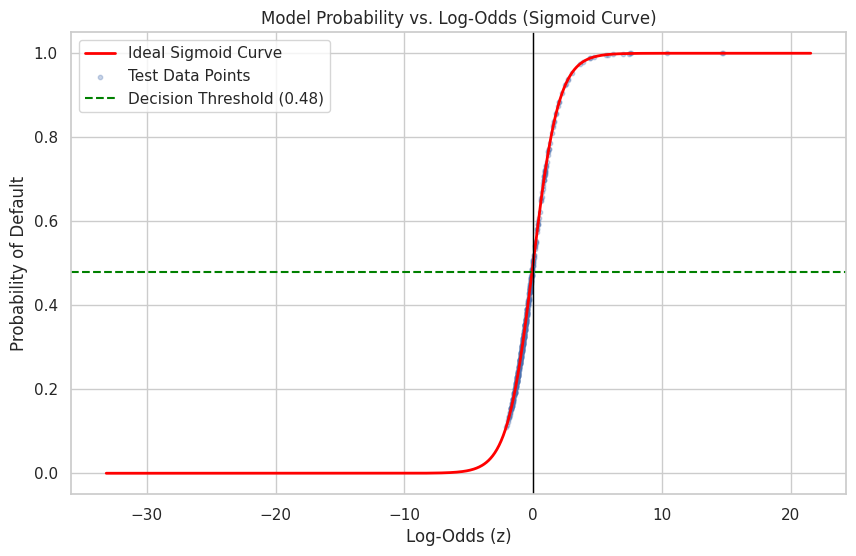

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 1. LOAD & INITIAL EDA 📊
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

print("========== 📊 INITIAL DATA HEALTH CHECK ==========")
# Check for Missing Values
print(f"Missing Values:\n{df.isnull().sum()}\n")

# Check Class Imbalance
default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

# Visualization 1: Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')

# ==========================================
# 2. DATA CLEANING & OUTLIERS 🧹
# ==========================================
# Handle "System Error" outliers (96 and 98 lates)
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate']

for col in late_cols:
    # We replace impossible values with the median of the non-error data
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTING & IMPUTATION 🧠
# ==========================================
# Split FIRST to avoid data leakage
X_raw = df.drop('SeriousDlqin2yrs', axis=1)
y_raw = df['SeriousDlqin2yrs']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

# Smart Imputation: Calculate medians on TRAIN only
income_median = X_train_raw['MonthlyIncome'].median()
dep_median = X_train_raw['NumberOfDependents'].median()

# Apply to both
for d in [X_train_raw, X_test_raw]:
    d['MonthlyIncome'] = d['MonthlyIncome'].fillna(income_median)
    d['NumberOfDependents'] = d['NumberOfDependents'].fillna(dep_median)

# ==========================================
# 4. OPTIMIZED FEATURE ENGINEERING 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # Behavior Interaction
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # Financial Capacity
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    # Income Metrics
    d['Monthly_Debt_Amt'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amt']

    # Fairness/Maturity Proxies
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Drop raw late columns to reduce multicollinearity
    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                           'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfTimes90DaysLate'])

X_train_eng = engineer_features(X_train_raw)
X_test_eng = engineer_features(X_test_raw)

# Visualization 2: Final Feature Correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_eng.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Optimized Features')
plt.savefig('correlation_heatmap.png')

# ==========================================
# 5. SCALING & MODELING ⚖️
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

# Logistic Regression with Class Weights to handle imbalance
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Find Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
best_t = thresholds[optimal_idx]

y_pred = (y_probs >= best_t).astype(int)
auc_score = roc_auc_score(y_test, y_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)
rec_val = tp / (tp + fn)

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred):.4f}")
print(f"Recall:            {rec_val:.4f}")
print(f"F1-Score:          {f1_score(y_test, y_pred):.4f}")

# Visualization 3: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal Threshold')
plt.savefig('confusion_matrix_lr.png')
print("✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'")

# Visualizing the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec_val, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lr.png')
print("✅ ROC Curve Generated: 'roc_curve_lr.png'")

# ==========================================
# 7. SIGMOID FUNCTION VISUALIZATION 📈
# ==========================================
z = model.decision_function(X_test_scaled)
plt.figure(figsize=(10, 6))
z_smooth = np.linspace(z.min(), z.max(), 1000)
p_smooth = 1 / (1 + np.exp(-z_smooth))
plt.plot(z_smooth, p_smooth, color='red', label='Ideal Sigmoid Curve', linewidth=2)

indices = np.random.choice(len(z), 500)
plt.scatter(z[indices], y_probs[indices], alpha=0.3, s=10, label='Test Data Points')
plt.axhline(y=best_t, color='green', linestyle='--', label=f'Decision Threshold ({best_t:.2f})')
plt.axvline(x=0, color='black', linewidth=1)
plt.title('Model Probability vs. Log-Odds (Sigmoid Curve)')
plt.xlabel('Log-Odds (z)')
plt.ylabel('Probability of Default')
plt.legend()
plt.savefig('sigmoid_curve.png')
print("✅ Sigmoid Curve Generated: 'sigmoid_curve.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test_raw['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ AGE BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")
print(f"Disparate Impact Ratio:     {young_app/senior_app:.4f}")

if (young_app/senior_app) < 0.8:
    print("🚨 ALERT: Model shows potential age bias (below 80% rule).")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

# Create a results df to show impact
results_lr = pd.DataFrame({
    'Actual_Default': y_test,
    'Prob_Default': y_probs
})
results_lr['Risk_Tier'] = results_lr['Prob_Default'].apply(categorize_risk)

tier_summary_lr = results_lr.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum')
).reset_index()

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary_lr.to_string(index=False))
print("=================================================\n")

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Dataset Imbalance: 6.68% are Defaulters.


/tmp/ipython-input-3420328448.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')


✅ EDA Visualization Generated: 'target_distribution.png'


/tmp/ipython-input-3420328448.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3420328448.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3420328448.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3420328448.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3420328448.py:61: FutureWarning: 

Passin

KeyboardInterrupt: 

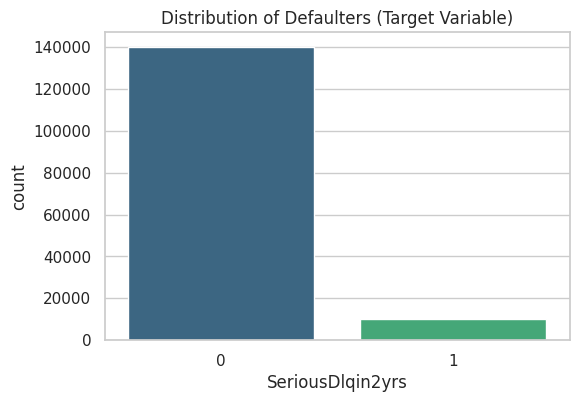

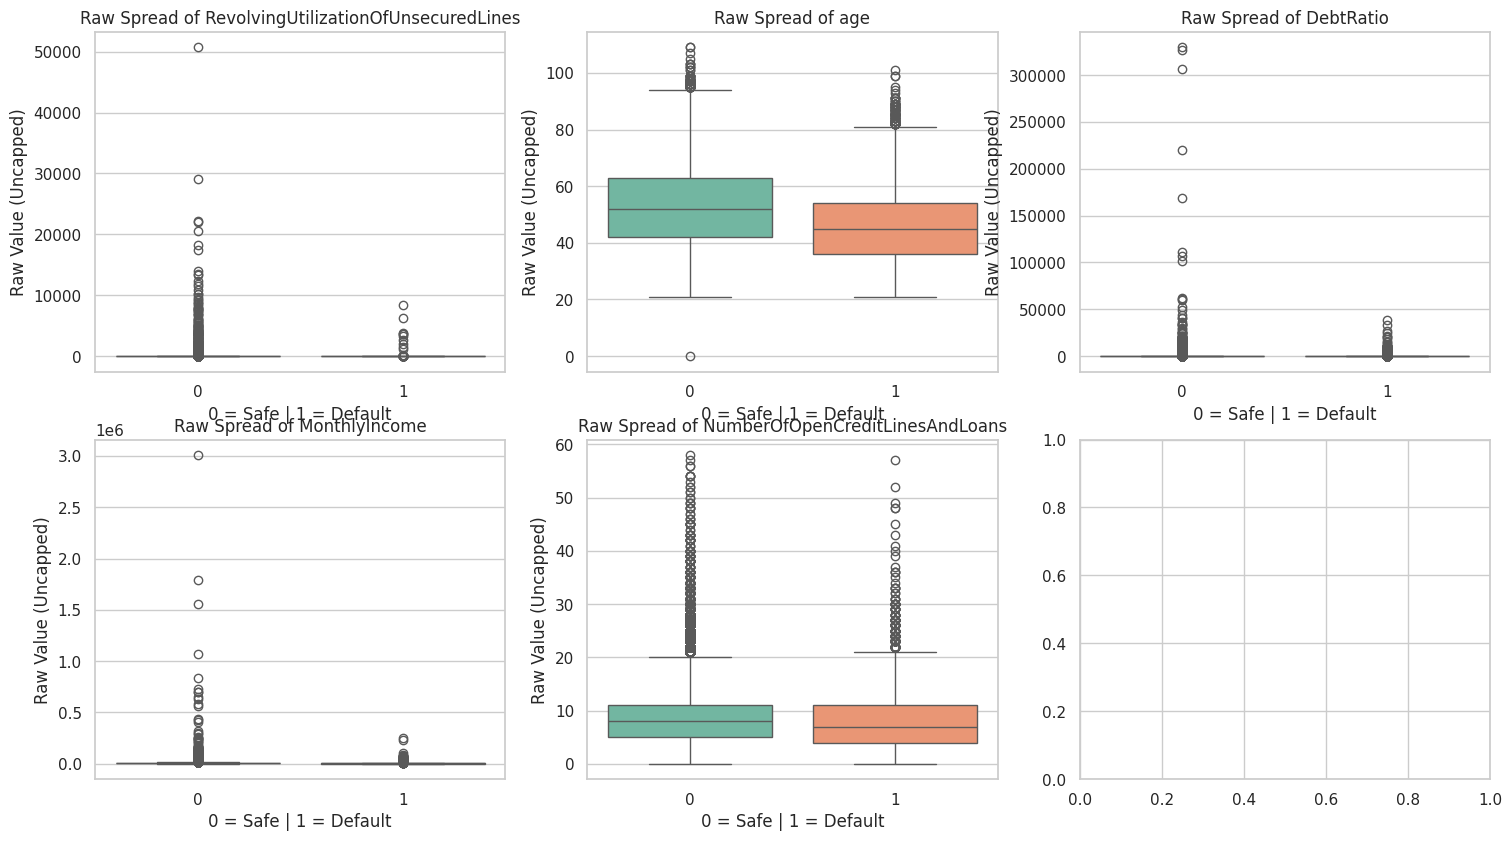

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1A. INITIAL EDA & TARGET DISTRIBUTION 📊
# ==========================================
print("========== 📊 INITIAL DATA HEALTH CHECK ==========")
# Check for Missing Values
print(f"Missing Values:\n{df.isnull().sum()}\n")

# Check Class Imbalance
default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

# Visualization 1: Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')
print("✅ EDA Visualization Generated: 'target_distribution.png'")

# ==========================================
# 1B. EDA: RAW FEATURE RANGES & OUTLIERS (BOXPLOTS) 📊
# ==========================================
# 3x3 grid to fit all 9 core continuous/discrete features
plt.figure(figsize=(18, 15))

features_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)

    # Using entirely RAW data (no capping) to expose the extreme outliers
    plot_data = df.dropna(subset=[col])

    sns.boxplot(
        data=plot_data,
        x='SeriousDlqin2yrs',
        y=col,
        palette='Set2'
    )
    plt.title(f'Raw Spread of {col}')
    plt.xlabel('0 = Safe | 1 = Default')
    plt.ylabel('Raw Value (Uncapped)')

plt.tight_layout()
plt.savefig('raw_feature_ranges_boxplot_lr.png')
print("✅ EDA Visualization Generated: 'raw_feature_ranges_boxplot_lr.png'")

# ==========================================
# 2. DATA CLEANING & OUTLIERS 🧹
# ==========================================
# Handle "System Error" outliers (96 and 98 lates)
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate']

for col in late_cols:
    # We replace impossible values with the median of the non-error data
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTING & IMPUTATION 🧠
# ==========================================
# Split FIRST to avoid data leakage
X_raw = df.drop('SeriousDlqin2yrs', axis=1)
y_raw = df['SeriousDlqin2yrs']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

# Smart Imputation: Calculate medians on TRAIN only
income_median = X_train_raw['MonthlyIncome'].median()
dep_median = X_train_raw['NumberOfDependents'].median()

# Apply to both
for d in [X_train_raw, X_test_raw]:
    d['MonthlyIncome'] = d['MonthlyIncome'].fillna(income_median)
    d['NumberOfDependents'] = d['NumberOfDependents'].fillna(dep_median)

# ==========================================
# 4. OPTIMIZED FEATURE ENGINEERING 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # Behavior Interaction
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # Financial Capacity
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    # Income Metrics
    d['Monthly_Debt_Amt'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amt']

    # Fairness/Maturity Proxies
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Drop raw late columns to reduce multicollinearity
    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                           'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfTimes90DaysLate'])

X_train_eng = engineer_features(X_train_raw)
X_test_eng = engineer_features(X_test_raw)

# Visualization 2: Final Feature Correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_eng.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Optimized Features')
plt.savefig('correlation_heatmap_lr.png')
print("✅ Correlation Heatmap Generated: 'correlation_heatmap_lr.png'")

# ==========================================
# 5. SCALING & MODELING ⚖️
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

# Logistic Regression with Class Weights to handle imbalance
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Find Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
best_t = thresholds[optimal_idx]

y_pred = (y_probs >= best_t).astype(int)
auc_score = roc_auc_score(y_test, y_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)
rec_val = tp / (tp + fn)

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred):.4f}")
print(f"Recall:            {rec_val:.4f}")
print(f"F1-Score:          {f1_score(y_test, y_pred):.4f}")

# Visualization 3: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal Threshold')
plt.savefig('confusion_matrix_lr.png')
print("✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'")

# Visualizing the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec_val, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lr.png')
print("✅ ROC Curve Generated: 'roc_curve_lr.png'")

# ==========================================
# 7. SIGMOID FUNCTION VISUALIZATION 📈
# ==========================================
z = model.decision_function(X_test_scaled)
plt.figure(figsize=(10, 6))
# Create a smooth sigmoid curve line
z_smooth = np.linspace(z.min(), z.max(), 1000)
p_smooth = 1 / (1 + np.exp(-z_smooth))
plt.plot(z_smooth, p_smooth, color='red', label='Ideal Sigmoid Curve', linewidth=2)

# Plot actual data points (sampled for readability)
indices = np.random.choice(len(z), 500)
plt.scatter(z[indices], y_probs[indices], alpha=0.3, s=10, label='Test Data Points')

plt.axhline(y=best_t, color='green', linestyle='--', label=f'Decision Threshold ({best_t:.2f})')
plt.axvline(x=0, color='black', linewidth=1)
plt.title('Model Probability vs. Log-Odds (Sigmoid Curve)')
plt.xlabel('Log-Odds (z)')
plt.ylabel('Probability of Default')
plt.legend()
plt.savefig('sigmoid_curve_lr.png')
print("✅ Sigmoid Curve Generated: 'sigmoid_curve_lr.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test_raw['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ AGE BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")
print(f"Disparate Impact Ratio:     {young_app/senior_app:.4f}")

if (young_app/senior_app) < 0.8:
    print("🚨 ALERT: Model shows potential age bias (below 80% rule).")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

# Create a results df to show impact
results_lr = pd.DataFrame({
    'Actual_Default': y_test,
    'Prob_Default': y_probs
})
results_lr['Risk_Tier'] = results_lr['Prob_Default'].apply(categorize_risk)

tier_summary_lr = results_lr.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum')
).reset_index()

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary_lr.to_string(index=False))
print("=================================================\n")

✅ Dropped 609 duplicate rows.

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

Dataset Imbalance: 6.70% are Defaulters.

========== 🔢 SUMMARY STATISTICS (Raw Data) ==========
                                         count         mean           std  \
SeriousDlqin2yrs                      149391.0     0.066999      0.250021   
RevolvingUtilizationOfUnsecuredLines  149391.0     6.071087    250.263672   
age                                   149391.0    52.306

/tmp/ipython-input-810738476.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')


✅ EDA Visualization Generated: 'target_distribution.png'


/tmp/ipython-input-810738476.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-810738476.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-810738476.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-810738476.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

✅ EDA Visualization Generated: 'raw_feature_ranges_boxplot_lr.png'
✅ EDA Visualization Generated: 'l_shape_quirk.png'
✅ Normality Check Generated: 'normality_check.png'
✅ Smart Splitter: Building Test Set from 100% pure, non-imputed data.
✅ Correlation Heatmap Generated: 'correlation_heatmap_lr.png'

========== 🏆 FINAL MODEL PERFORMANCE ==========
AUC Score:         0.8557
Optimal Threshold: 0.4991
Accuracy:          0.7774
Precision:         0.1997
Recall:            0.7722
F1-Score:          0.3174
✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'
✅ ROC Curve Generated: 'roc_curve_lr.png'
✅ Sigmoid Curve Generated: 'sigmoid_curve_lr.png'

========== ⚖️ AGE BIAS AUDIT ==========
Young Approval Rate (<30):  53.11%
Senior Approval Rate (30+): 75.43%
Disparate Impact Ratio:     0.7041
🚨 ALERT: Model shows potential age bias (below 80% rule).

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Risk (Manual Review):   0.15 to 0.4991
Hi

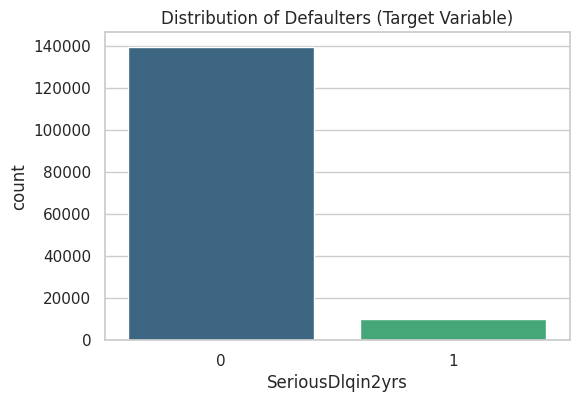

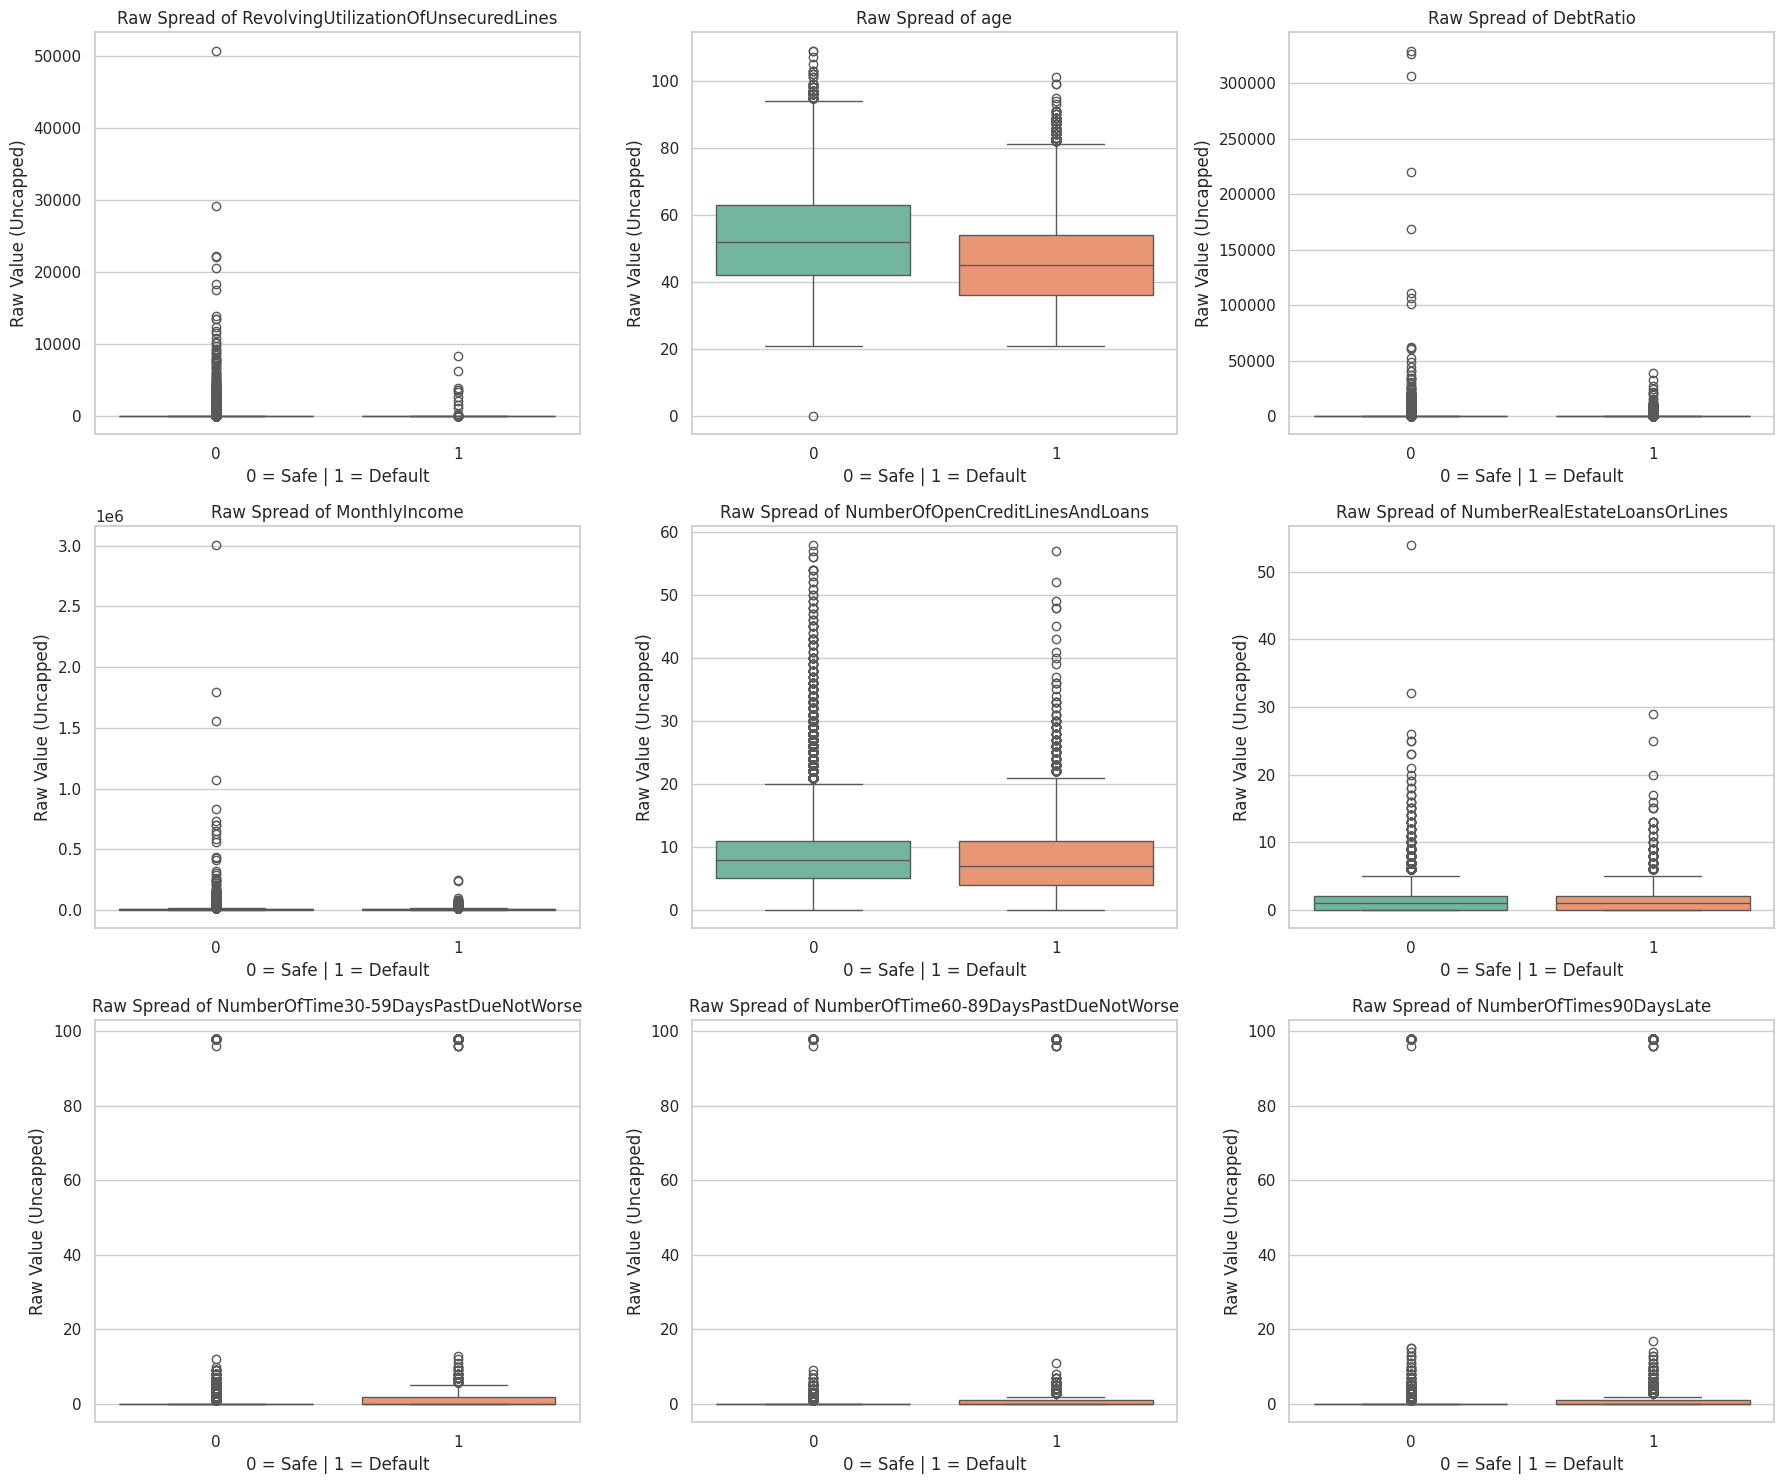

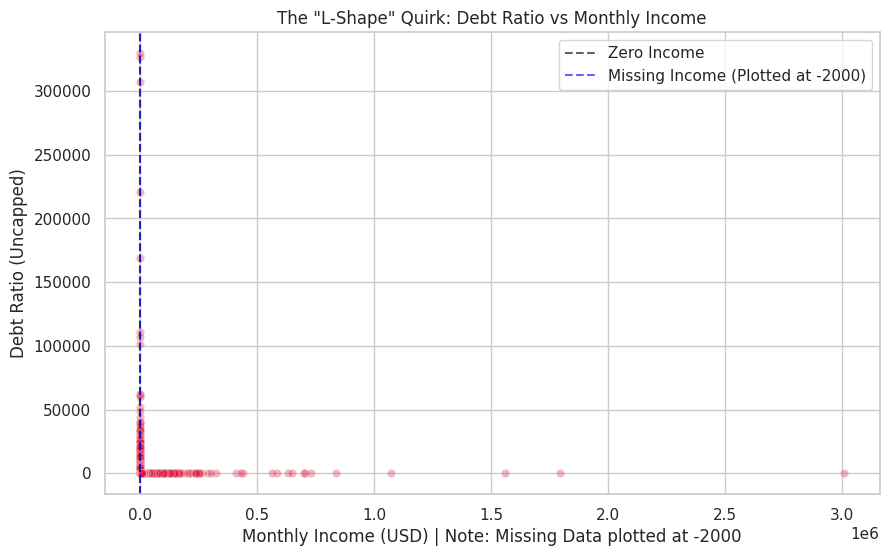

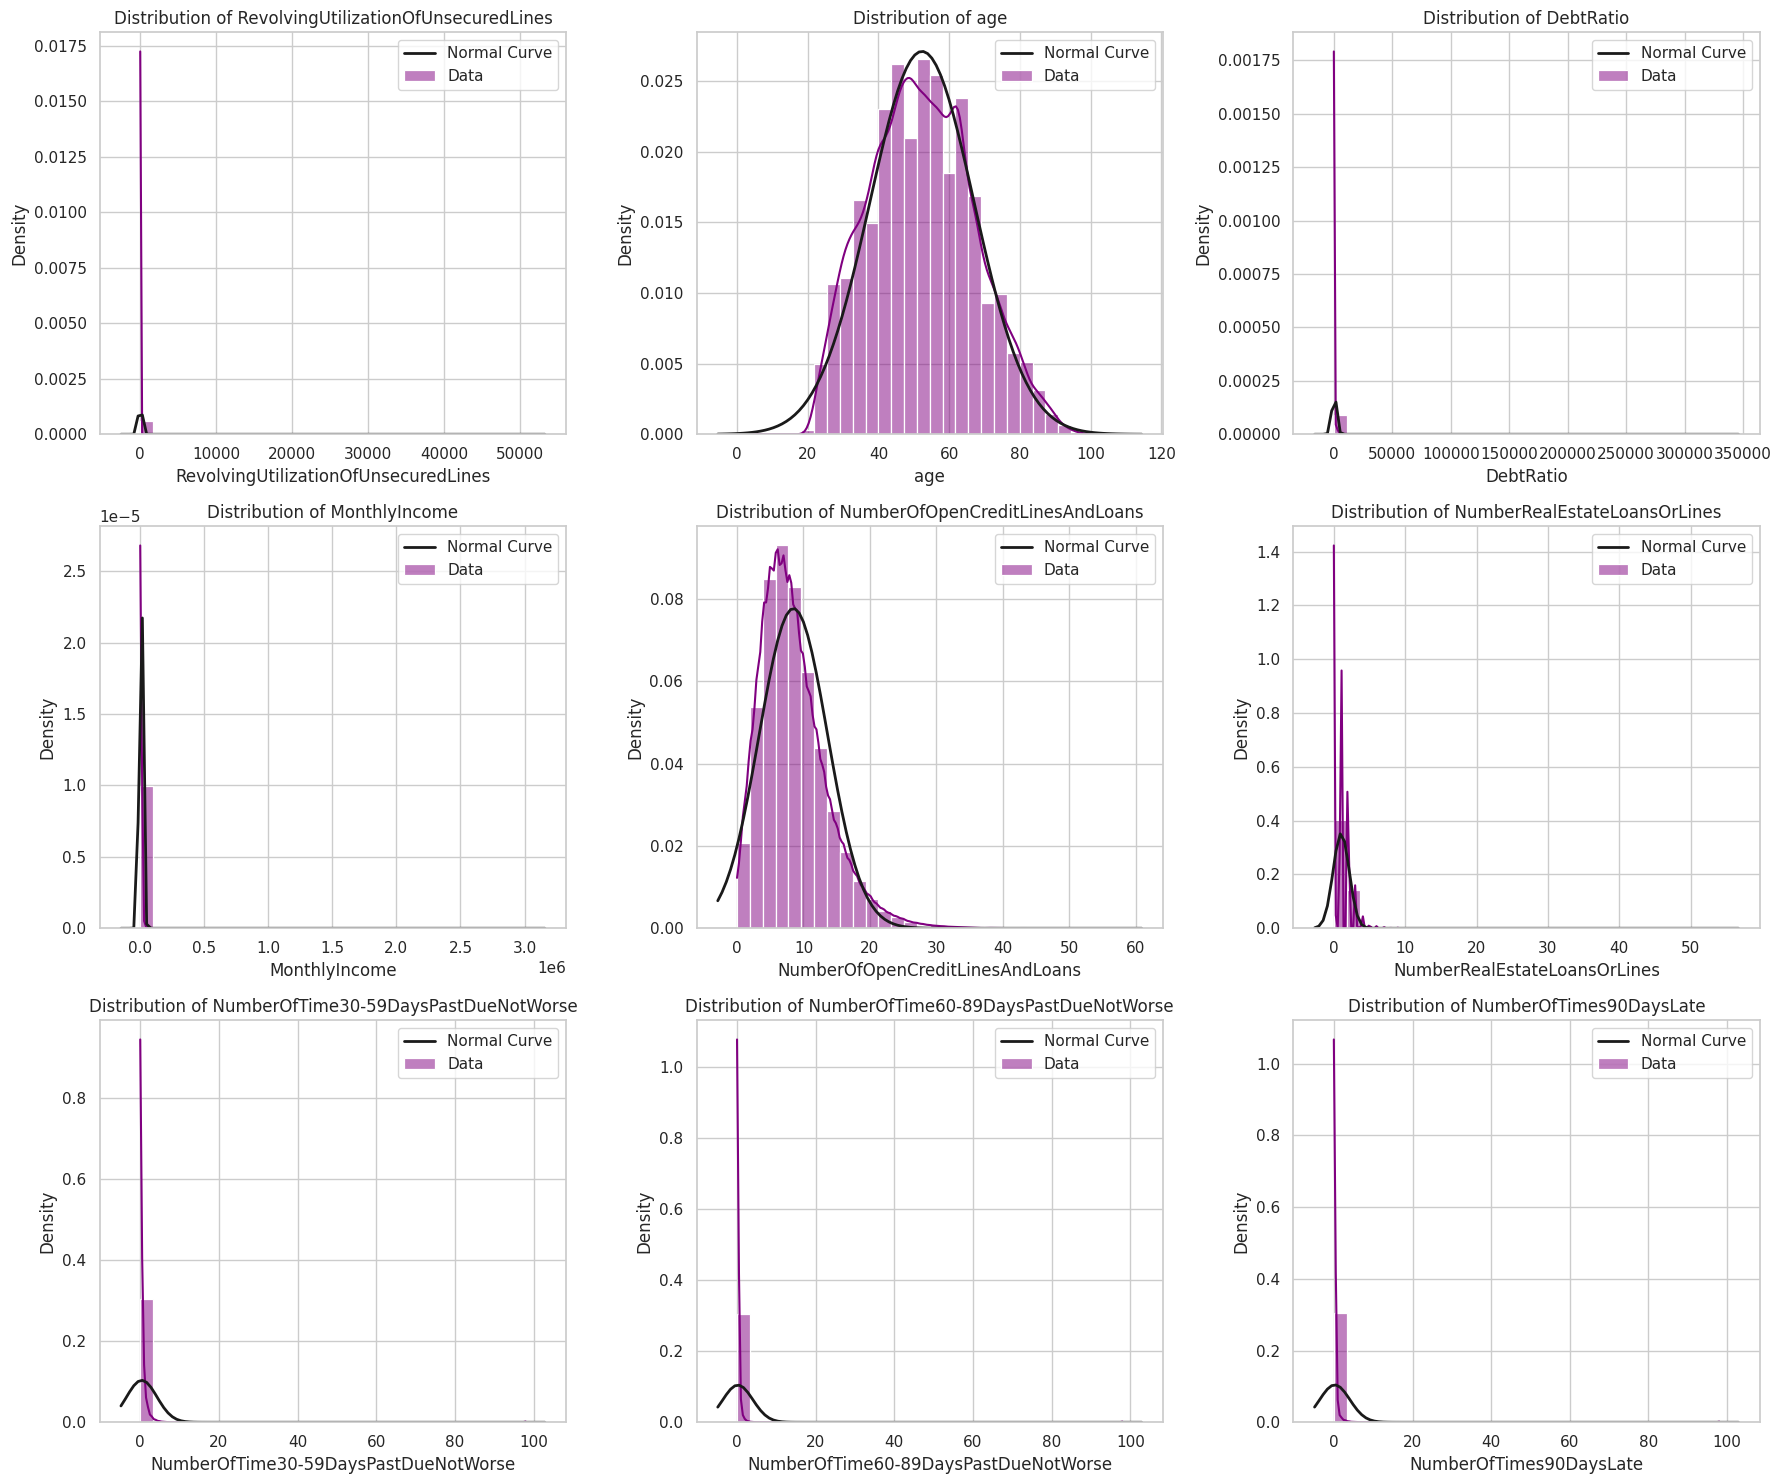

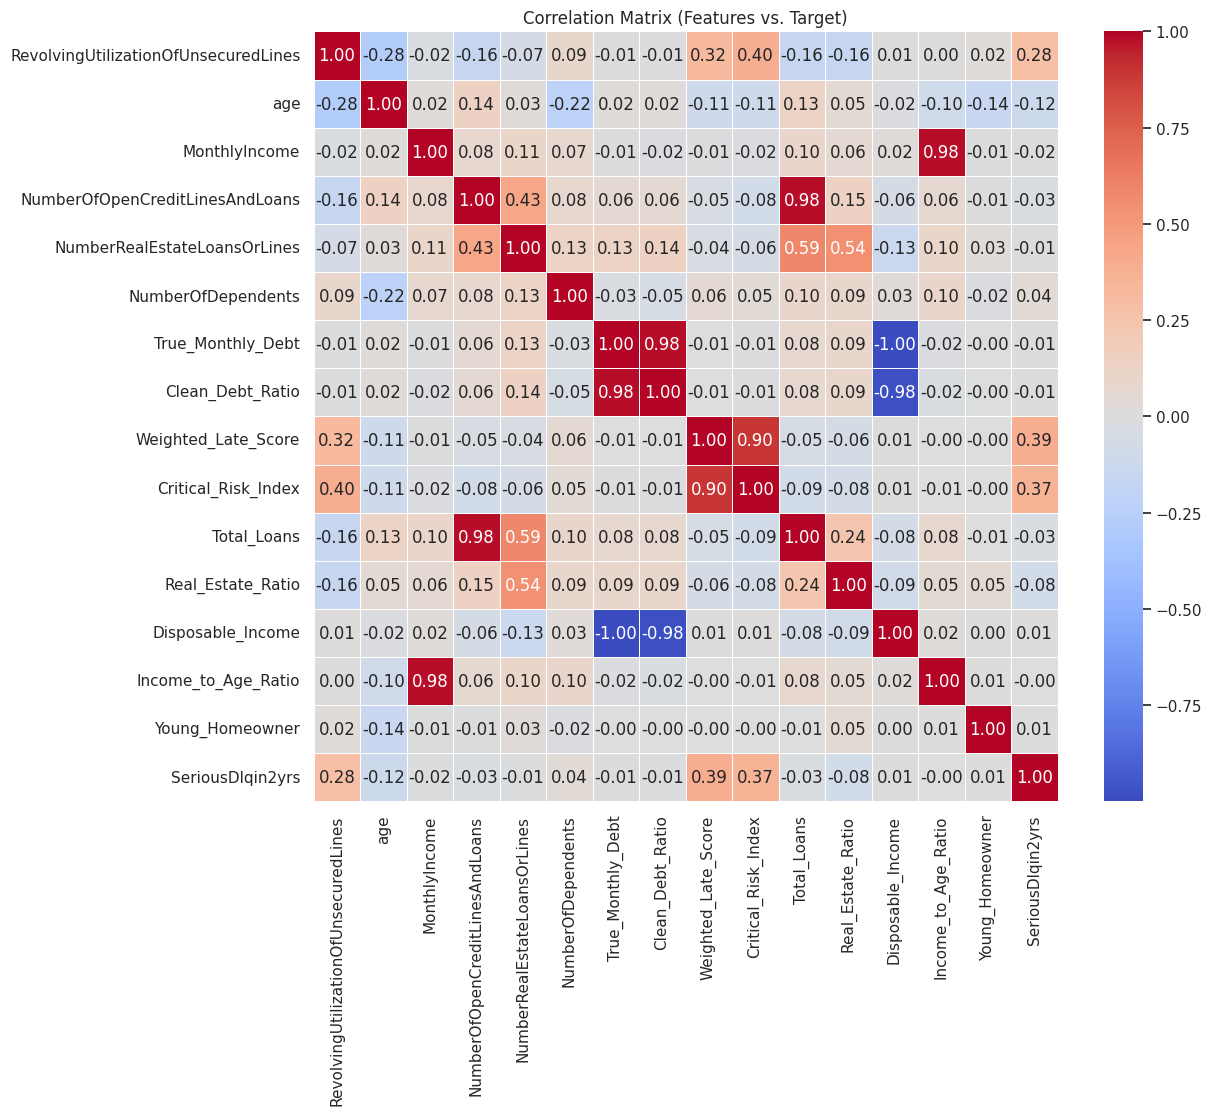

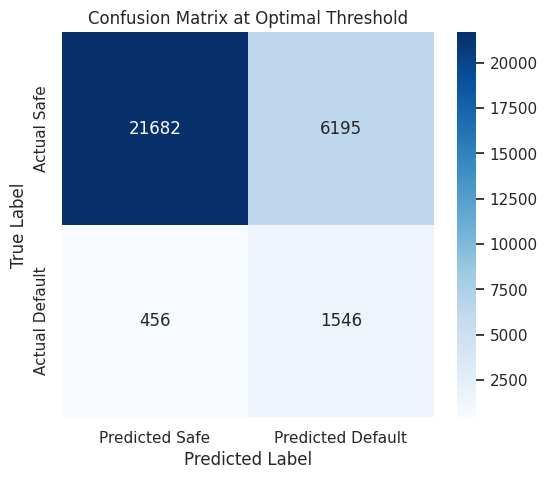

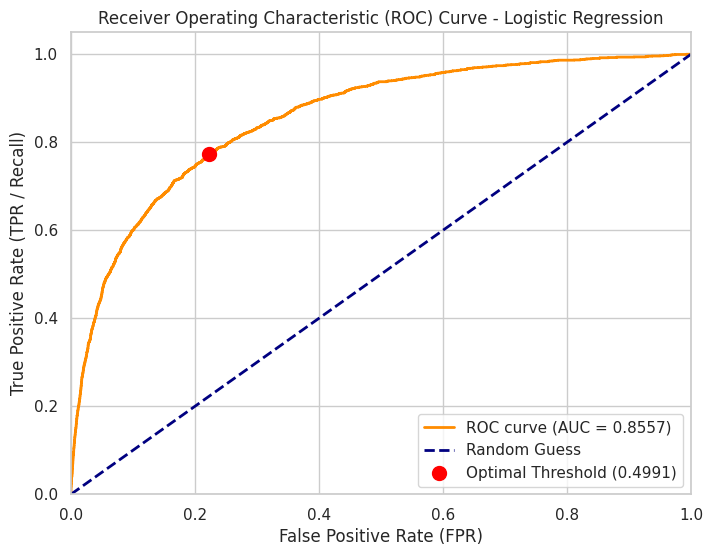

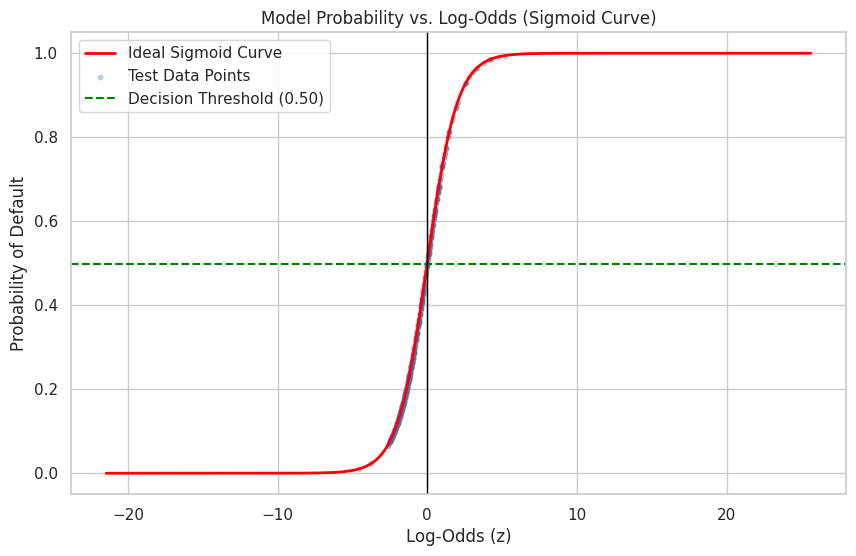

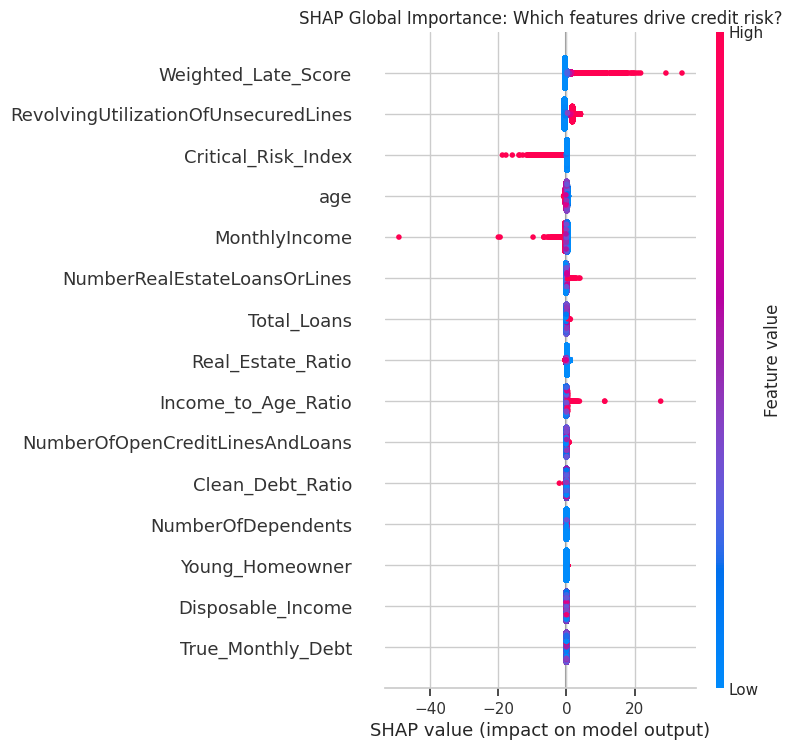

<Figure size 640x480 with 0 Axes>

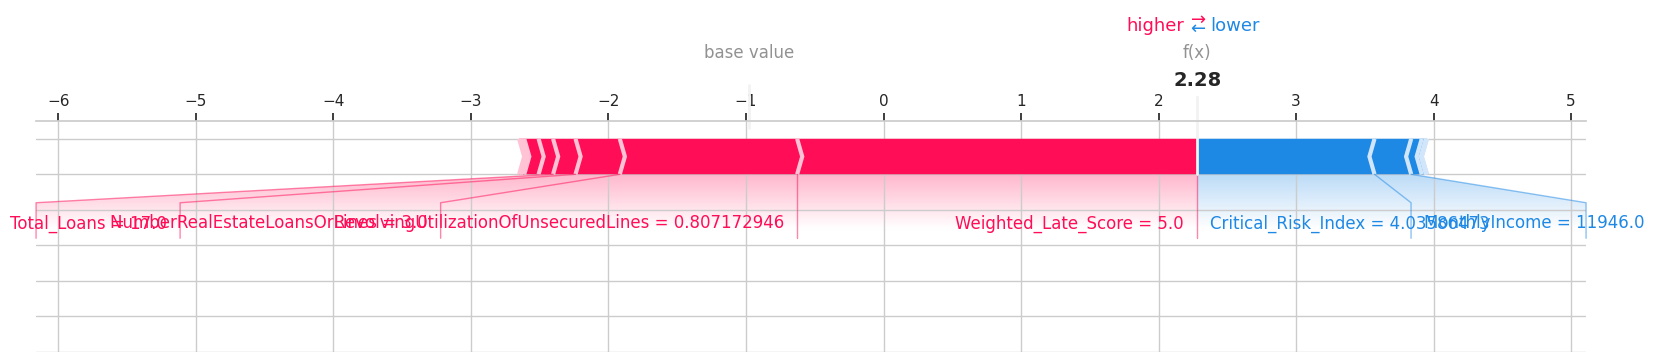

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 0. LOAD DATA & DROP DUPLICATES 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# Drop exact duplicate rows (Multi-pull phenomenon)
initial_shape = df.shape
df = df.drop_duplicates()
print(f"✅ Dropped {initial_shape[0] - df.shape[0]} duplicate rows.")

# ==========================================
# 1A. INITIAL EDA & TARGET DISTRIBUTION 📊
# ==========================================
print("\n========== 📊 INITIAL DATA HEALTH CHECK ==========")
print(f"Missing Values:\n{df.isnull().sum()}\n")

default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

# ADD THIS BLOCK 👇
print("\n========== 🔢 SUMMARY STATISTICS (Raw Data) ==========")
# We use .T (Transpose) to make it readable. Look at the 'max' column!
print(df.describe().T)

plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')
print("✅ EDA Visualization Generated: 'target_distribution.png'")

# ==========================================
# 1B. EDA: RAW FEATURE RANGES & OUTLIERS 📊
# ==========================================
plt.figure(figsize=(18, 15))
features_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    plot_data = df.dropna(subset=[col])
    sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
    plt.title(f'Raw Spread of {col}')
    plt.xlabel('0 = Safe | 1 = Default')
    plt.ylabel('Raw Value (Uncapped)')

plt.tight_layout()
plt.savefig('raw_feature_ranges_boxplot_lr.png')
print("✅ EDA Visualization Generated: 'raw_feature_ranges_boxplot_lr.png'")

# ==========================================
# 1C. EDA: THE "L-SHAPE" DEBT RATIO QUIRK 📊
# ==========================================
plt.figure(figsize=(10, 6))
plot_df = df[['MonthlyIncome', 'DebtRatio']].copy()

# Fill missing income with -2000 to visualize it on the plot
plot_df['MonthlyIncome'] = plot_df['MonthlyIncome'].fillna(-2000)

sns.scatterplot(x='MonthlyIncome', y='DebtRatio', data=plot_df, alpha=0.3, color='crimson')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.6, label='Zero Income')
plt.axvline(x=-2000, color='blue', linestyle='--', alpha=0.6, label='Missing Income (Plotted at -2000)')

plt.title('The "L-Shape" Quirk: Debt Ratio vs Monthly Income')
plt.xlabel('Monthly Income (USD) | Note: Missing Data plotted at -2000')
plt.ylabel('Debt Ratio (Uncapped)')
plt.legend()
plt.savefig('l_shape_quirk.png')
print("✅ EDA Visualization Generated: 'l_shape_quirk.png'")

# ==========================================
# 1D. FEATURE DISTRIBUTIONS (NORMALITY CHECK) 📊
# ==========================================
import scipy.stats as stats

plt.figure(figsize=(18, 15))
cols_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
]

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(3, 3, i)

    # Drop missing values just for plotting to avoid errors
    data_clean = df[col].dropna()

    # 1. Plot the Histogram (The Data)
    sns.histplot(data_clean, kde=True, bins=30, color='purple', stat='density', label='Data')

    # 2. Plot a Theoretical Normal Distribution Curve (The Ideal Bell Curve)
    # We fit a normal curve to the data's mean and std dev to compare
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = stats.norm.fit(data_clean)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal Curve')

    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.savefig('normality_check.png')
print("✅ Normality Check Generated: 'normality_check.png'")

# ==========================================
# 2. DATA CLEANING & OUTLIERS 🧹
# ==========================================
# Handle "System Error" outliers (96 and 98 lates)
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate']

for col in late_cols:
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. YOUR ORIGINAL SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

# We want the test set to be ONLY real, non-imputed data if possible
clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    print("✅ Smart Splitter: Building Test Set from 100% pure, non-imputed data.")
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only to prevent Data Leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    print("⚠️ Smart Splitter: Not enough pure data, falling back to standard split.")
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 4. OPTIMIZED FEATURE ENGINEERING & FIXES 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # --- 1. FIX KAGGLE DATABASE QUIRKS ---
    # Fix Age 0 Typo
    d.loc[d['age'] < 18, 'age'] = d['age'].median()

    # Cap Runaway Utilization (Maxed out = 1.0, cap at 2.0 to remove 50,000 system errors)
    d['RevolvingUtilizationOfUnsecuredLines'] = np.clip(d['RevolvingUtilizationOfUnsecuredLines'], 0, 2.0)

    # Reverse-Engineer DebtRatio back to true Absolute Debt
    d['True_Monthly_Debt'] = np.where(
        d['MonthlyIncome'] <= 1,
        d['DebtRatio'],
        d['DebtRatio'] * d['MonthlyIncome']
    )
    safe_income = np.where(d['MonthlyIncome'] <= 1, 1, d['MonthlyIncome'])
    d['Clean_Debt_Ratio'] = d['True_Monthly_Debt'] / safe_income

    # --- 2. STANDARD BEHAVIORAL ENGINEERING ---
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    d['Disposable_Income'] = d['MonthlyIncome'] - d['True_Monthly_Debt']

    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / d['age']
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Drop the original broken columns
    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                           'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfTimes90DaysLate',
                           'DebtRatio'])

# 🚨 Both Train and Test pass through the filter here!
train_df_eng = engineer_features(train_df)
test_df_eng = engineer_features(test_df)

X_train_eng = train_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df_eng['SeriousDlqin2yrs']
X_test_eng = test_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df_eng['SeriousDlqin2yrs']

# Visualization 2: Final Feature Correlation (Including Target!)
plt.figure(figsize=(12, 10))

# 1. Create a temporary combined DataFrame
corr_df = X_train_eng.copy()
corr_df['SeriousDlqin2yrs'] = y_train # Add the target variable back in

# 2. Plot correlation of EVERYTHING
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix (Features vs. Target)')
plt.savefig('correlation_heatmap_lr.png')
print("✅ Correlation Heatmap Generated: 'correlation_heatmap_lr.png'")

# ==========================================
# 5. SCALING & MODELING ⚖️
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
best_t = thresholds[optimal_idx]

y_pred = (y_probs >= best_t).astype(int)
auc_score = roc_auc_score(y_test, y_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)
rec_val = tp / (tp + fn)

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred):.4f}")
print(f"Recall:            {rec_val:.4f}")
print(f"F1-Score:          {f1_score(y_test, y_pred):.4f}")

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal Threshold')
plt.savefig('confusion_matrix_lr.png')
print("✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec_val, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lr.png')
print("✅ ROC Curve Generated: 'roc_curve_lr.png'")

# ==========================================
# 7. SIGMOID FUNCTION VISUALIZATION 📈
# ==========================================
z = model.decision_function(X_test_scaled)
plt.figure(figsize=(10, 6))
z_smooth = np.linspace(z.min(), z.max(), 1000)
p_smooth = 1 / (1 + np.exp(-z_smooth))
plt.plot(z_smooth, p_smooth, color='red', label='Ideal Sigmoid Curve', linewidth=2)

indices = np.random.choice(len(z), 500)
plt.scatter(z[indices], y_probs[indices], alpha=0.3, s=10, label='Test Data Points')

plt.axhline(y=best_t, color='green', linestyle='--', label=f'Decision Threshold ({best_t:.2f})')
plt.axvline(x=0, color='black', linewidth=1)
plt.title('Model Probability vs. Log-Odds (Sigmoid Curve)')
plt.xlabel('Log-Odds (z)')
plt.ylabel('Probability of Default')
plt.legend()
plt.savefig('sigmoid_curve_lr.png')
print("✅ Sigmoid Curve Generated: 'sigmoid_curve_lr.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test_eng['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ AGE BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")
print(f"Disparate Impact Ratio:     {young_app/senior_app:.4f}")

if (young_app/senior_app) < 0.8:
    print("🚨 ALERT: Model shows potential age bias (below 80% rule).")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

results_lr = pd.DataFrame({
    'Actual_Default': y_test,
    'Prob_Default': y_probs
})
results_lr['Risk_Tier'] = results_lr['Prob_Default'].apply(categorize_risk)

tier_summary_lr = results_lr.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum')
).reset_index()

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary_lr.to_string(index=False))
print("=================================================\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # <--- NEW IMPORT
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# ... [Keep Sections 0 through 9 exactly as they are in your code] ...

# ==========================================
# 10. SHAP EXPLAINABILITY (MODEL INTERPRETATION) 🔍
# ==========================================
# For Logistic Regression, we use LinearExplainer
# We pass the scaled training data as a background distribution
explainer = shap.LinearExplainer(model, X_train_scaled, feature_names=X_train_eng.columns.tolist())
shap_values = explainer.shap_values(X_test_scaled)

# Plot 1: Global Feature Importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train_eng.columns.tolist(), show=False)
plt.title('SHAP Global Importance: Which features drive credit risk?')
plt.savefig('shap_summary_lr.png', bbox_inches='tight')
print("✅ SHAP Summary Plot Generated: 'shap_summary_lr.png'")

# Plot 2: Individual Force Plot (Example for the 1st person in the test set)
# This shows exactly WHY the model gave this person their specific score
plt.figure()
shap.plots.force(explainer.expected_value, shap_values[0, :], X_test_eng.iloc[0, :], matplotlib=True, show=False)
plt.savefig('shap_individual_explanation.png', bbox_inches='tight')
print("✅ Individual SHAP Explanation Generated: 'shap_individual_explanation.png'")

✅ Dropped 609 duplicate rows.

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

Dataset Imbalance: 6.70% are Defaulters.


/tmp/ipython-input-578148945.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')


✅ EDA Visualization Generated: 'target_distribution.png'


/tmp/ipython-input-578148945.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-578148945.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-578148945.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-578148945.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

✅ EDA Visualization Generated: 'raw_feature_ranges_boxplot_lr.png'
✅ EDA Visualization Generated: 'l_shape_quirk.png'
✅ Smart Splitter: Building Test Set from 100% pure, non-imputed data.
✅ Correlation Heatmap Generated: 'correlation_heatmap_lr.png'

========== 🏆 FINAL MODEL PERFORMANCE ==========
AUC Score:         0.8557
Optimal Threshold: 0.4794
Accuracy:          0.7646
Precision:         0.1925
Recall:            0.7867
F1-Score:          0.3093
✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'
✅ ROC Curve Generated: 'roc_curve_lr.png'
✅ Sigmoid Curve Generated: 'sigmoid_curve_lr.png'

========== ⚖️ AGE BIAS AUDIT ==========
Young Approval Rate (<30):  51.99%
Senior Approval Rate (30+): 73.93%
Disparate Impact Ratio:     0.7032
🚨 ALERT: Model shows potential age bias (below 80% rule).

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Risk (Manual Review):   0.15 to 0.4794
High Risk (Auto-Reject):       > 0.4794

--- TIER IMP

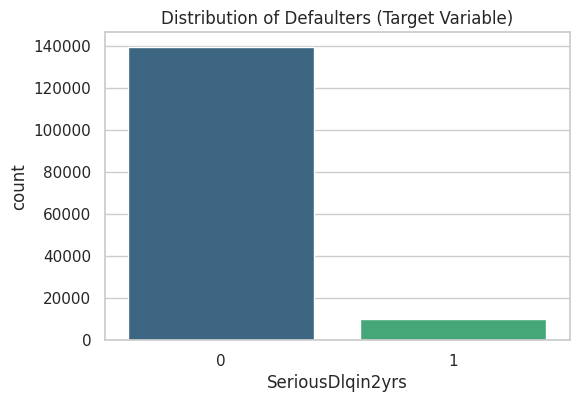

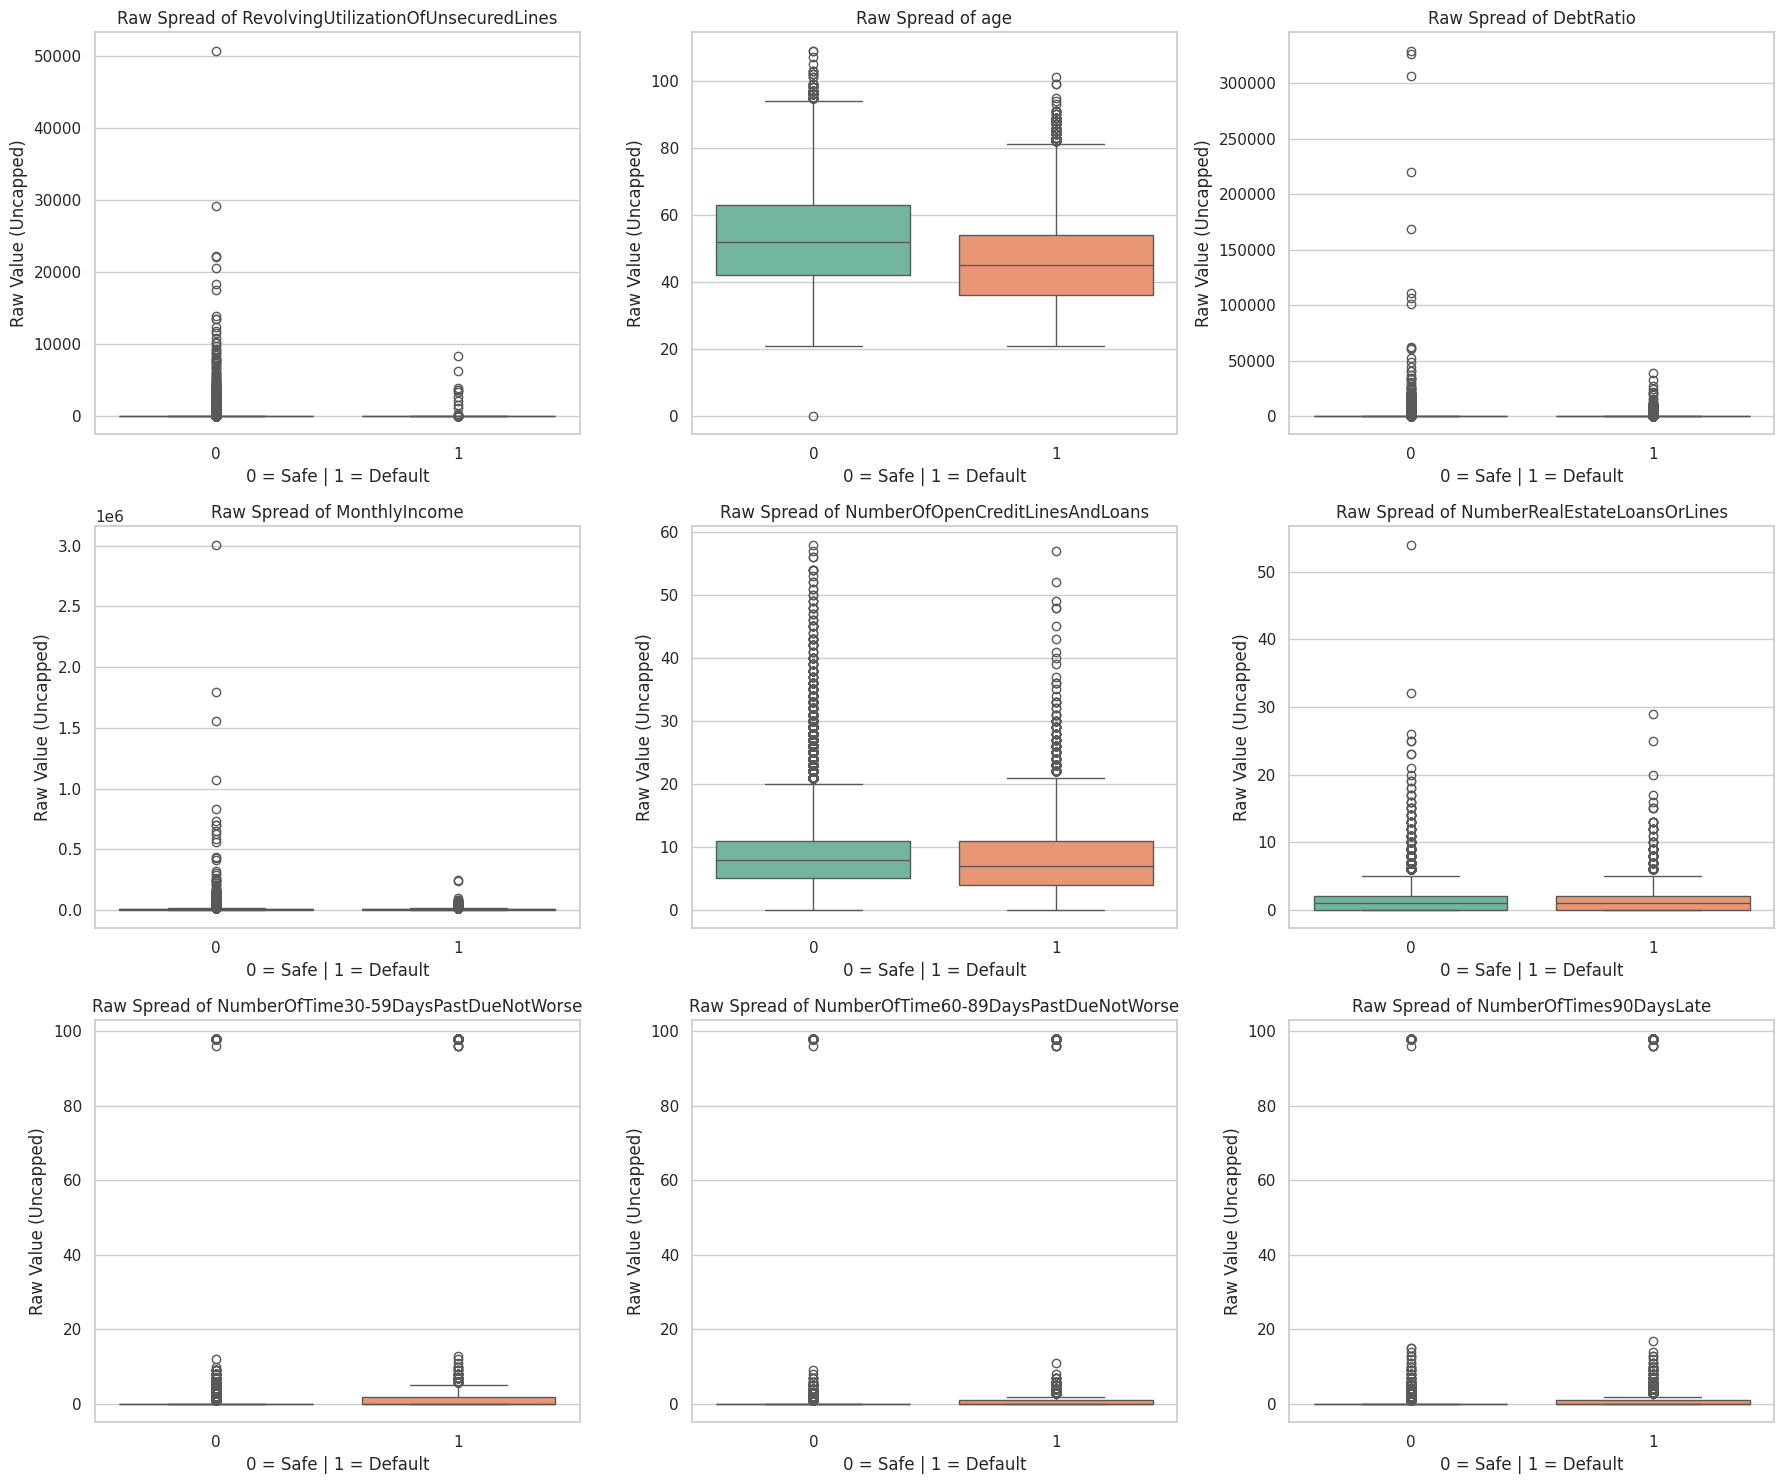

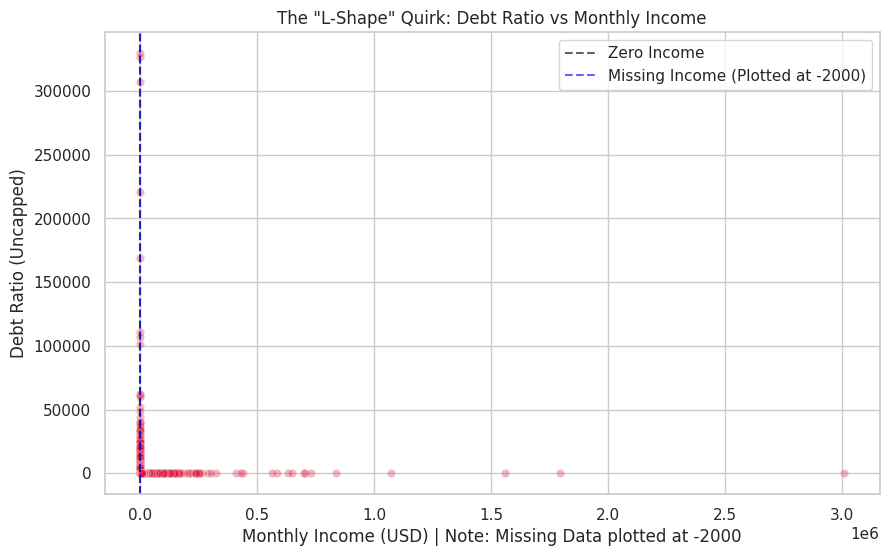

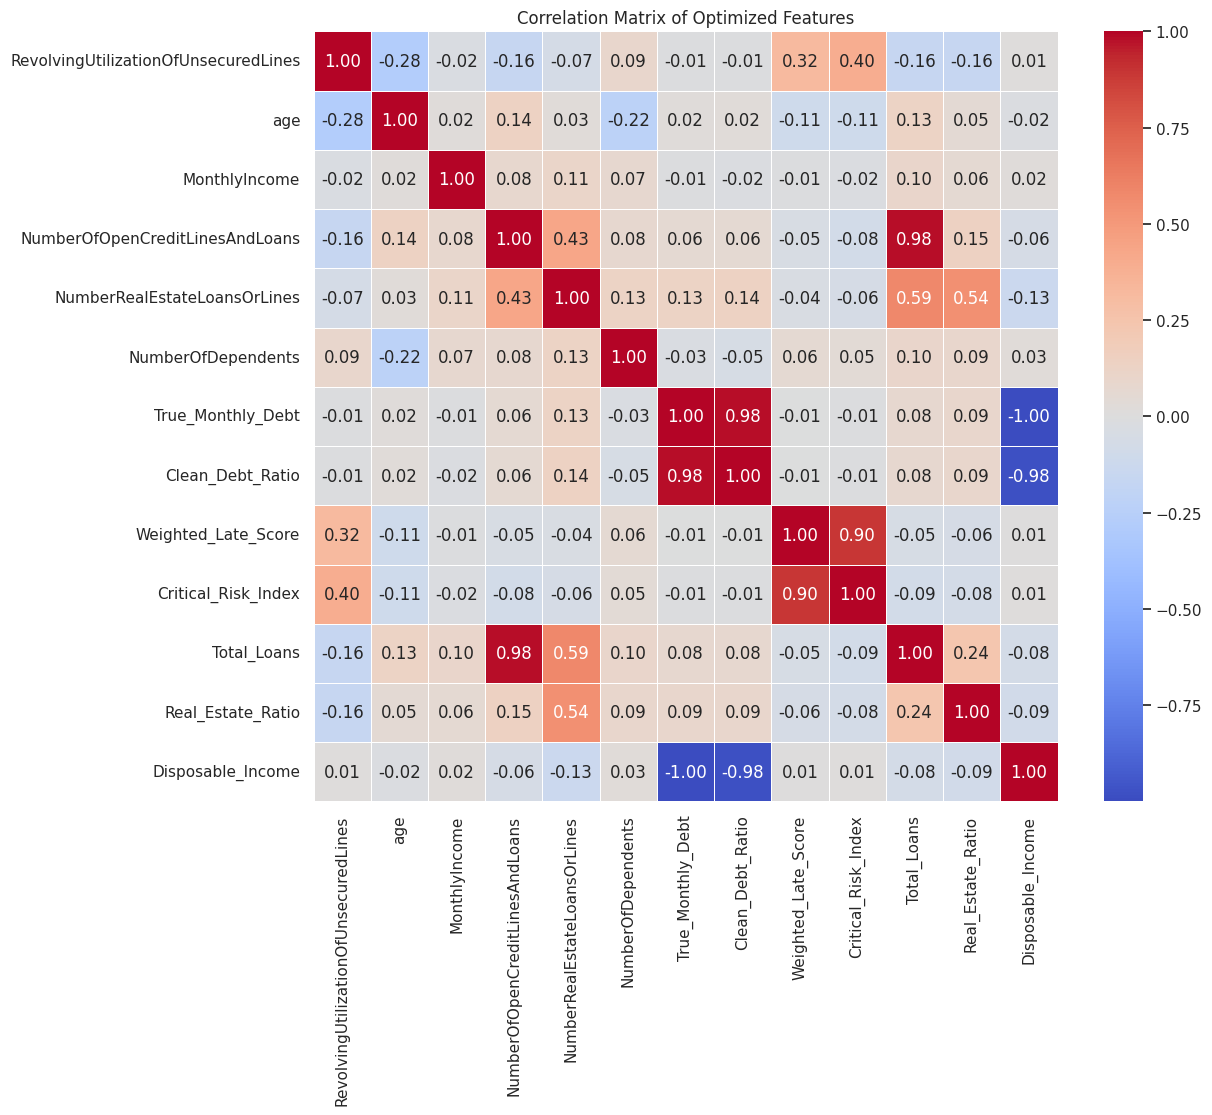

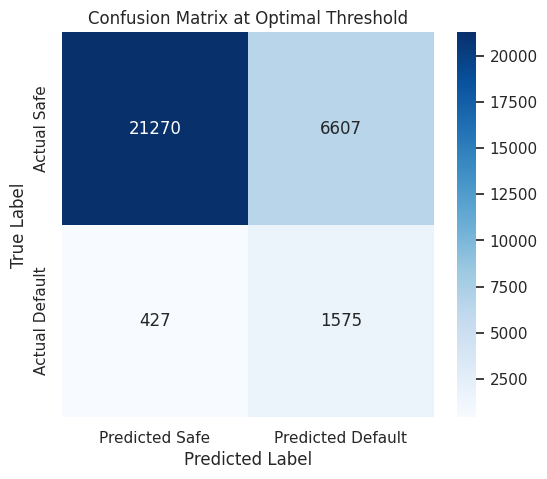

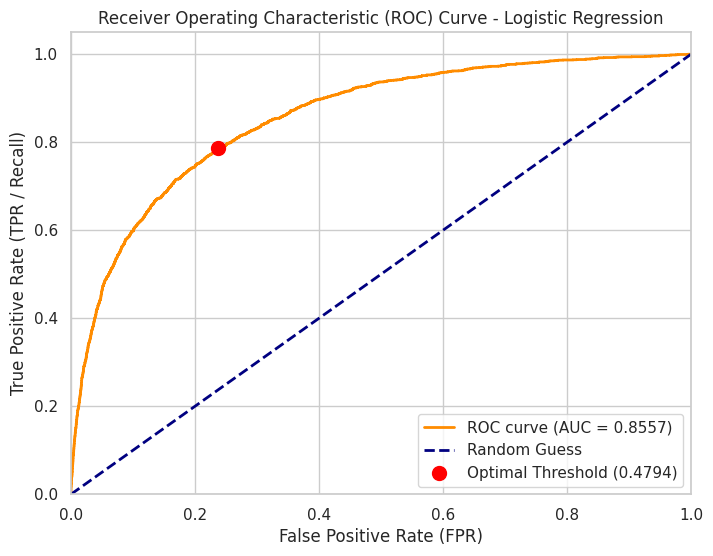

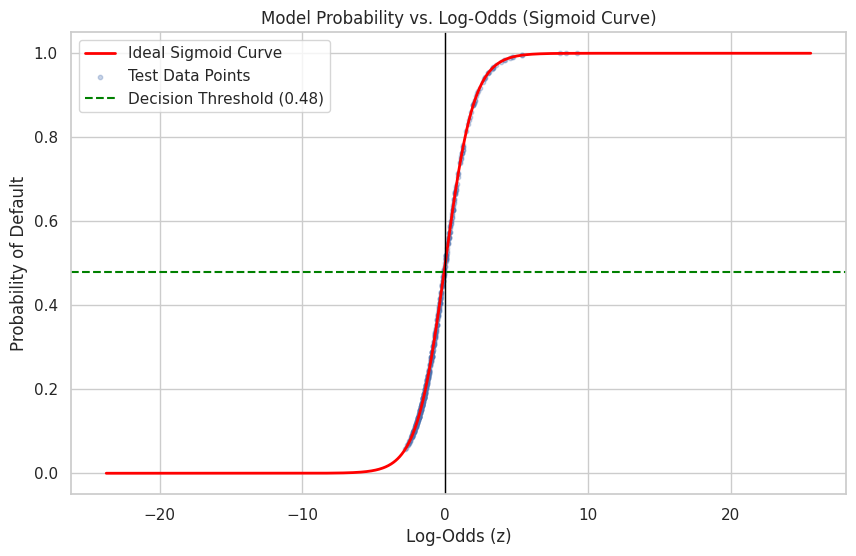

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, f1_score)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 0. LOAD DATA & DROP DUPLICATES 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# Drop exact duplicate rows (Multi-pull phenomenon)
initial_shape = df.shape
df = df.drop_duplicates()
print(f"✅ Dropped {initial_shape[0] - df.shape[0]} duplicate rows.")

# ==========================================
# 1A. INITIAL EDA & TARGET DISTRIBUTION 📊
# ==========================================
print("\n========== 📊 INITIAL DATA HEALTH CHECK ==========")
print(f"Missing Values:\n{df.isnull().sum()}\n")

default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')
print("✅ EDA Visualization Generated: 'target_distribution.png'")

# ==========================================
# 1B. EDA: RAW FEATURE RANGES & OUTLIERS 📊
# ==========================================
plt.figure(figsize=(18, 15))
features_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    plot_data = df.dropna(subset=[col])
    sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
    plt.title(f'Raw Spread of {col}')
    plt.xlabel('0 = Safe | 1 = Default')
    plt.ylabel('Raw Value (Uncapped)')

plt.tight_layout()
plt.savefig('raw_feature_ranges_boxplot_lr.png')
print("✅ EDA Visualization Generated: 'raw_feature_ranges_boxplot_lr.png'")

# ==========================================
# 1C. EDA: THE "L-SHAPE" DEBT RATIO QUIRK 📊
# ==========================================
plt.figure(figsize=(10, 6))
plot_df = df[['MonthlyIncome', 'DebtRatio']].copy()

# Fill missing income with -2000 to visualize it on the plot
plot_df['MonthlyIncome'] = plot_df['MonthlyIncome'].fillna(-2000)

sns.scatterplot(x='MonthlyIncome', y='DebtRatio', data=plot_df, alpha=0.3, color='crimson')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.6, label='Zero Income')
plt.axvline(x=-2000, color='blue', linestyle='--', alpha=0.6, label='Missing Income (Plotted at -2000)')

plt.title('The "L-Shape" Quirk: Debt Ratio vs Monthly Income')
plt.xlabel('Monthly Income (USD) | Note: Missing Data plotted at -2000')
plt.ylabel('Debt Ratio (Uncapped)')
plt.legend()
plt.savefig('l_shape_quirk.png')
print("✅ EDA Visualization Generated: 'l_shape_quirk.png'")

# ==========================================
# 2. DATA CLEANING & OUTLIERS 🧹
# ==========================================
# Handle "System Error" outliers (96 and 98 lates)
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate']

for col in late_cols:
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

# We want the test set to be ONLY real, non-imputed data if possible
clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    print("✅ Smart Splitter: Building Test Set from 100% pure, non-imputed data.")
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only to prevent Data Leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    print("⚠️ Smart Splitter: Not enough pure data, falling back to standard split.")
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 4. OPTIMIZED FEATURE ENGINEERING & FIXES 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # --- 1. FIX KAGGLE DATABASE QUIRKS ---
    # Fix Age 0 Typo
    d.loc[d['age'] < 18, 'age'] = d['age'].median()

    # Cap Runaway Utilization (Maxed out = 1.0, cap at 2.0 to remove 50,000 system errors)
    d['RevolvingUtilizationOfUnsecuredLines'] = np.clip(d['RevolvingUtilizationOfUnsecuredLines'], 0, 2.0)

    # Reverse-Engineer DebtRatio back to true Absolute Debt
    d['True_Monthly_Debt'] = np.where(
        d['MonthlyIncome'] <= 1,
        d['DebtRatio'],
        d['DebtRatio'] * d['MonthlyIncome']
    )
    safe_income = np.where(d['MonthlyIncome'] <= 1, 1, d['MonthlyIncome'])
    d['Clean_Debt_Ratio'] = d['True_Monthly_Debt'] / safe_income

    # --- 2. STANDARD BEHAVIORAL ENGINEERING ---
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    d['Disposable_Income'] = d['MonthlyIncome'] - d['True_Monthly_Debt']

    # Drop the original broken columns
    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse',
                           'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfTimes90DaysLate',
                           'DebtRatio'])

# 🚨 Both Train and Test pass through the filter here!
train_df_eng = engineer_features(train_df)
test_df_eng = engineer_features(test_df)

X_train_eng = train_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df_eng['SeriousDlqin2yrs']
X_test_eng = test_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df_eng['SeriousDlqin2yrs']

# Visualization 2: Final Feature Correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_eng.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Optimized Features')
plt.savefig('correlation_heatmap_lr.png')
print("✅ Correlation Heatmap Generated: 'correlation_heatmap_lr.png'")

# ==========================================
# 5. SCALING & MODELING ⚖️
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
best_t = thresholds[optimal_idx]

y_pred = (y_probs >= best_t).astype(int)
auc_score = roc_auc_score(y_test, y_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)
rec_val = tp / (tp + fn)

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred):.4f}")
print(f"Recall:            {rec_val:.4f}")
print(f"F1-Score:          {f1_score(y_test, y_pred):.4f}")

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal Threshold')
plt.savefig('confusion_matrix_lr.png')
print("✅ Confusion Matrix Generated: 'confusion_matrix_lr.png'")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec_val, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lr.png')
print("✅ ROC Curve Generated: 'roc_curve_lr.png'")

# ==========================================
# 7. SIGMOID FUNCTION VISUALIZATION 📈
# ==========================================
z = model.decision_function(X_test_scaled)
plt.figure(figsize=(10, 6))
z_smooth = np.linspace(z.min(), z.max(), 1000)
p_smooth = 1 / (1 + np.exp(-z_smooth))
plt.plot(z_smooth, p_smooth, color='red', label='Ideal Sigmoid Curve', linewidth=2)

indices = np.random.choice(len(z), 500)
plt.scatter(z[indices], y_probs[indices], alpha=0.3, s=10, label='Test Data Points')

plt.axhline(y=best_t, color='green', linestyle='--', label=f'Decision Threshold ({best_t:.2f})')
plt.axvline(x=0, color='black', linewidth=1)
plt.title('Model Probability vs. Log-Odds (Sigmoid Curve)')
plt.xlabel('Log-Odds (z)')
plt.ylabel('Probability of Default')
plt.legend()
plt.savefig('sigmoid_curve_lr.png')
print("✅ Sigmoid Curve Generated: 'sigmoid_curve_lr.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
# Extract the updated age data (where Age 0 was fixed) to test against our predictions
results_bias = pd.DataFrame({'age': X_test_eng['age'], 'pred': y_pred})

# Calculate the approval rate (predicting 0 / Safe) for both groups
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ AGE BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")

# The 80% rule: Is the minority approval rate at least 80% of the majority approval rate?
disparate_impact = young_app / senior_app
print(f"Disparate Impact Ratio:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows potential age bias (below 80% rule).")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

results_lr = pd.DataFrame({
    'Actual_Default': y_test,
    'Prob_Default': y_probs
})
results_lr['Risk_Tier'] = results_lr['Prob_Default'].apply(categorize_risk)

tier_summary_lr = results_lr.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum')
).reset_index()

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary_lr.to_string(index=False))
print("=================================================\n")